##  Clinical Diagnosis Prediction from Medical Transcripts/Anamnesis
#### Member: Joy Zhuge, Gemeng Zhang

### Background

Primary health care is essential for most people, but making an appointment with a doctor could be exhausting and time-consuming in modern life. It would be great to have an AI healthcare chatbot to assure the anxiety before making the reservation. Image the scenario, we can make a self-diagnosis right after having some symptoms, and then decide which specialists to visit.
We attempt to predict clinical diagnosis from medical transcripts/anamnesis, although the prediction might not be accurate at all. On one side, patients can save time and money with a positive attitude; on the other side, doctors can serve more efficiently on sparing time on unreliable diagnosis.


### Dataset Info

We will use the medical transcription sample reports and examples from https://www.mtsamples.com. The data contains around 5000 sample transcription reports for many specialties provided by various transcriptionists and users and are for reference purpose only. The data is also available on Kaggle (https://www.kaggle.com/tboyle10/medicaltranscriptions) . In our problem setting, we are interested in two aspects of the data: the sample medical transcription as features and medical speciality as labels. In the dataset, 40 types of specialties are provided as labels with an unbalanced distribution ((min,max) = (7, 1103)).

In [2]:
# Dependent libraries
# Basic libraries

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import random
import itertools
from collections import defaultdict
import string

# Preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from itertools import combinations
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import gensim
from gensim.summarization import summarize
#from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
#from keras.utils import to_categorical
#from imblearn.under_sampling import NearMiss, RandomUnderSampler
#from imblearn.over_sampling import SMOTE, ADASYN
import torch
# import torchtext
# Models

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
#import lightgbm as lgb

# Evaluation

from sklearn.metrics import classification_report,f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, make_scorer
#from lime import lime_text
from sklearn.pipeline import make_pipeline
#from lime.lime_text import LimeTextExplainer


import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

## Data Preview

In [2]:
# load data
data = pd.read_csv('mtsamples.csv')
print(data.shape)
data.head()

(4999, 6)


Unnamed: 0                                        description  \
0           0   A 23-year-old white female presents with comp...   
1           1           Consult for laparoscopic gastric bypass.   
2           2           Consult for laparoscopic gastric bypass.   
3           3                             2-D M-Mode. Doppler.     
4           4                                 2-D Echocardiogram   

             medical_specialty                                sample_name  \
0         Allergy / Immunology                         Allergic Rhinitis    
1                   Bariatrics   Laparoscopic Gastric Bypass Consult - 2    
2                   Bariatrics   Laparoscopic Gastric Bypass Consult - 1    
3   Cardiovascular / Pulmonary                    2-D Echocardiogram - 1    
4   Cardiovascular / Pulmonary                    2-D Echocardiogram - 2    

                                       transcription  \
0  SUBJECTIVE:,  This 23-year-old white female pr...   
1  PAST MEDICAL HISTORY:, He has difficulty climb...   
2  HISTORY OF PRESENT ILLNESS: , I have seen ABC ...   
3  2-D M-MODE: , ,1.  Left atrial enlargement wit...   
4  1.  The left ventricular cavity size and wall ...   

                                            keywords  
0  allergy / immunology, allergic rhinitis, aller...  
1  bariatrics, laparoscopic gastric bypass, weigh...  
2  bariatrics, laparoscopic gastric bypass, heart...  
3  cardiovascular / pulmonary, 2-d m-mode, dopple...  
4  cardiovascular / pulmonary, 2-d, doppler, echo...

After the load the dataset, we can see there are five columns including the "description", "medical_specialty", "sample_name", "transcription" and "keywords". In our project, we are interested in predicting the medical specialty according to the transcription records, so we will only keep those two columns for further use. Moreover, we would like to check if there are any empty entry in the left two columns and discard those entries accordingly.

In [3]:
# extract the medical specialty and transcriptions
data = data[['transcription', 'medical_specialty']]

# remove the data entry with NaN
data = data.drop(data[data['transcription'].isna()].index)
data = data.drop(data[data['medical_specialty'].isna()].index)
print(data.shape)

(4966, 2)


It seems 33 data porints were removed due to the empty entry! Now, let's take a look at our feature, the transcription context. Although it should be vectorized for further modeling, clearly understanding of the words is the pivot for successful feature extraction. The transcription is the detailed description of patients' symptoms from the physicians or doctors. For example, we can show the transcription for the first patient in the list. We can see there are several keywords appearing in the context like "SUBJECTIVE", "MEDICATIONS","ALLERGIES","OBJECTIVE", "ASSESSMENT" and "PLAN", which seems to be a very well-organized text form.


In an ideal condition, we would like the transcription to be a highly structured form, which will be in favor of further analysis. However, we found this tale is not applicable in this pratice as we check more patients data. The transcription of the second patients just has a different list of record: PAST MEDICAL HISTORY, "PAST SURGICAL HISTORY","SOCIAL HISTORY", "FAMILY HISTORY","CURRENT MEDICATIONS", "ALLERGIES","MISCELLANEOUS/EATING HISTORY","REVIEW OF SYSTEMS","PHYSICAL EXAMINATION". There is no doubt that it would be problematic if we just ignore those KEYWORDS and throw the whole paragraph into featurization. It seems we must firstly find a way to make use of (or skip) those KEYWORDS in our featurization. 

Similarly, we can check the meidcal specialty of the data. From the following results, we can see this is a unbalanced multi-classfication problem. There are total 40 labels containing 6 to 1088 samples in different classes. Hence, we also need to take this into consideration in our performance measure and classifier design.

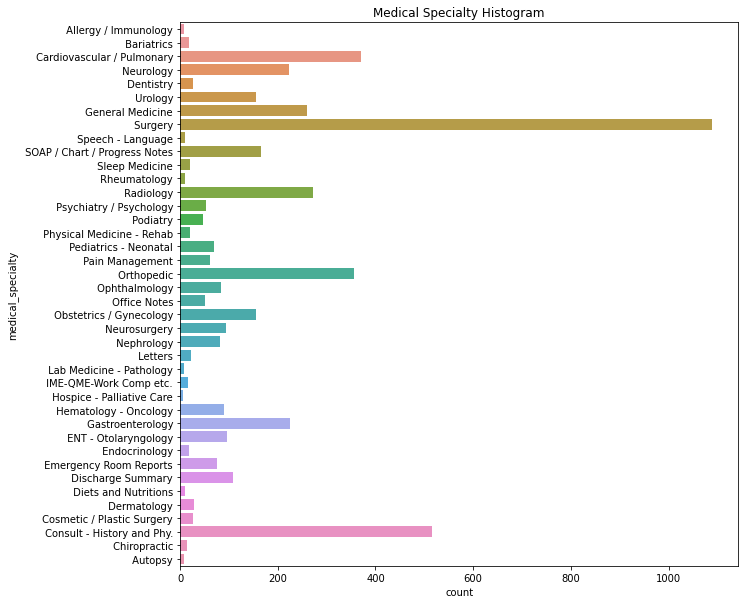

There are total of 40 labels for medical specialty
 Surgery                          1088
 Consult - History and Phy.        516
 Cardiovascular / Pulmonary        371
 Orthopedic                        355
 Radiology                         273
 General Medicine                  259
 Gastroenterology                  224
 Neurology                         223
 SOAP / Chart / Progress Notes     166
 Urology                           156
 Obstetrics / Gynecology           155
 Discharge Summary                 108
 ENT - Otolaryngology               96
 Neurosurgery                       94
 Hematology - Oncology              90
 Ophthalmology                      83
 Nephrology                         81
 Emergency Room Reports             75
 Pediatrics - Neonatal              70
 Pain Management                    61
 Psychiatry / Psychology            53
 Office Notes                       50
 Podiatry                           47
 Dermatology                        29
 Dentistry   

In [4]:
fig = plt.figure(figsize=(10, 10)) 
plt.title('Medical Specialty Histogram')
plt.xlabel('Specialty Category')
plt.ylabel('Counts')
#plt.hist(data['medical_specialty'], edgecolor = 'black', bins = 20)
sns.countplot(y='medical_specialty', data = data )
plt.show()

print('There are total of', len(data['medical_specialty'].value_counts()), 
      'labels for medical specialty')
print(data['medical_specialty'].value_counts())

To make the transcription more clear and easier to tokenize, we would like to clean the dat in the following ways:
1. turn all the words into lower case
2. remove all the punctuations
3. remove all the numbers

In [5]:
translator_c = str.maketrans(string.punctuation, ' '*len(string.punctuation))
data['transcription_clear']=data['transcription'].apply(lambda x: ' '.join([i for i in str(x).lower().
                                            translate(translator_c).split(' ') if i.isalpha()]))

In [6]:
data.head(5)
data.iloc[2].transcription_clear

'history of present illness i have seen abc today he is a very pleasant gentleman who is years old pounds he is he has a bmi of he has been overweight for ten years since the age of at his highest he was pounds at his lowest he is pursuing surgical attempts of weight loss to feel good get healthy and begin to exercise again he wants to be able to exercise and play volleyball physically he is sluggish he gets tired quickly he does not go out often when he loses weight he always regains it and he gains back more than he lost his biggest weight loss is pounds and it was three months before he gained it back he did six months of not drinking alcohol and not taking in many calories he has been on multiple commercial weight loss programs including slim fast for one month one year ago and atkin s diet for one month two years ago past medical history he has difficulty climbing stairs difficulty with airline seats tying shoes used to public seating difficulty walking high cholesterol and high b

### Vectorization/Embedding

### Bag of words
Bag of Words takes a document from corpus and converts into a numeric vector by mapping each document word to a feature vector. We firstly used the automatic function __[CounteVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)__ in scikit-learn with default tokenizer. 

In [7]:
bow_vect=CountVectorizer(max_df = 98, min_df = 4, ngram_range = (1,1), binary = True)

bow_x=bow_vect.fit_transform(data['transcription_clear'].tolist())
bow_y=data['medical_specialty'].tolist()
print("There are " + str (len(bow_vect.get_feature_names()))+ " features in bag of words model")
bow_x

There are 11210 features in bag of words model


<4966x11210 sparse matrix of type '<class 'numpy.int64'>'
	with 226068 stored elements in Compressed Sparse Row format>

### TF-IDF
The bags of words method is simple and straight forward, but it treats all words equally that can't ditingush the common words like 'the','a' or rare words. One can also notice, there are many jargons in this medical-specified data set, like the chemical name of medicines. Those words can vary for differrent patients and will make the feature in bag of words become extremely larger. In our case, #features: #samples = 11210: 4966 when we set [max_df, min_df] = [98, 4] using 1-gram. This is already a high dimensional problem and tends to cause severe overfitting problem in the following classification step.

The term frequency-inverse document frequency(tf-idf) method measures a word depending on how frequency it occurs in a document and a corpus.
1. Term frequency measures the frequency of a word in a document---tf('word_i')=number of times of ‘word_i’ appears in document / total number of words in a document
2. Inverse document frequency measure how common of a word is across all the document in the corpus---idf('word_i')=log(number of total documents / number of a document with ‘word_i’ in it))
3. tf-idf('word_i')=tf('word_i') * idf('word_i')

Suppose word 'the' is present in all the 100 documents, idf('the')=log(100/100)=log1=0, in that case, the very common words tend to be lesser important.

In [8]:
tfidf_vect=TfidfVectorizer(max_df = 98, min_df = 2, binary = True, ngram_range = (1,1))
tfidf_x=tfidf_vect.fit_transform(data['transcription_clear'].tolist())
tfidf_y=data['medical_specialty'].tolist()
tfidf_x

<4966x18167 sparse matrix of type '<class 'numpy.float64'>'
	with 241724 stored elements in Compressed Sparse Row format>

### Word2Vec
copied from hw2

In [10]:
glove = gensim.downloader.load('glove-wiki-gigaword-50')
# glove = torchtext.vocab.GloVe(name="6B", # trained on Wikipedia 2014 corpus
#                              dim=50)   # embedding size = 100

AttributeError: module 'gensim' has no attribute 'downloader'

In [ ]:
def average_vectors(words, w2v):
    vectors_sum=np.zeros(len(w2v['the']))
    for word in words:
        if word in w2v:                            # some words are missing in w2v keys
            temp=w2v[word]
        else:
            temp = [0]*50
        vectors_sum+=temp
    vectors_average=(vectors_sum+[1]*50)/(len(words)+1) # some sample has no word in feature 
    return vectors_average

def max_vectors(words, w2v): 
    temp=np.zeros((len(words),len(w2v['the'])))
    for index, word in enumerate(words):
        if word in w2v:
            temp[index]=w2v[word]
        else:
            temp[index]=[0]*50   
    vectors_max=np.array([max(idx) for idx in zip(*temp)])
    return vectors_max

def min_vectors(words, w2v):
    # YOUR CODE HERE
    temp=np.zeros((len(words),len(w2v['the'])))
    for index, word in enumerate(words):
        if word in w2v:
            temp[index]=w2v[word]
        else:
            temp[index]=[0]*50 
    vectors_min=np.array([min(idx) for idx in zip(*temp)])
    return vectors_min

def min_max_vectors(words, w2v):
    # YOUR CODE HERE
    temp=np.zeros((len(words),len(w2v['the'])))
    for index, word in enumerate(words):
        if word in w2v:
            temp=w2v[word]
        else:
            temp = [0]*50
    vectors_min=np.array([min(idx) for idx in zip(*temp)])
    vectors_max=np.array([max(idx) for idx in zip(*temp)])
    vectors_min_max=np.concatenate((vectors_min,vectors_max))
    return vectors_min_max

In [ ]:
def make_word_vector_features(X, vocab, w2v, aggregation_fn):
    """
    a numpy.ndarray with n rows and d columns, where n is the number of documents
    in X and d is the word vector dimension resulting from aggregation_fn
    """
    # YOUR CODE HERE
    mylist=[]
    for i in range(X.shape[0]):
        words=vocab[X[i].indices]
        temp=aggregation_fn(words, w2v)
        mylist.append(temp)
    fn=np.array(mylist)
    return fn

In [ ]:
vocab = np.array(bow_vect.get_feature_names())
w2v_vec = make_word_vector_features(bow_x, vocab, glove, average_vectors)
w2v_vec

## Baseline Model
As our baseline model, we would like to use those features from TF-IDF, word2vec, and feed them into logistic regression and Naive Bayes. In our case, 

In [ ]:
labels = data['medical_specialty'].tolist()
cat_list = data.medical_specialty.unique()
cat_list = [cat for cat in cat_list]
cat_list

function to plot top five and bottom five features for each class

In [ ]:
def plot_coefficients(classifier, feature_names, top_features=5):
    for index in range(len(classifier.coef_)):
        coef = classifier.coef_[index]
        top_positive_coefficients = np.argsort(coef)[-top_features:]
        top_negative_coefficients = np.argsort(coef)[:top_features]
        top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 # create plot
        plt.figure(figsize=(15, 5))
        temp=coef[top_coefficients][5]
#         print(temp)
        colors = ['red' if c < temp else 'blue' for c in coef[top_coefficients]]
        plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
        feature_names = np.array(feature_names)
#         print(top_coefficients)
        plt.xticks(np.arange(2 * top_features), feature_names[top_coefficients])
        plt.title(classifier.classes_[index])
    plt.show()

### Logistic regression with bag of words

In [ ]:
# bag of words + logistic regression

x_train, x_test, y_train, y_test = train_test_split(bow_x, labels, 
                                                    stratify=labels,test_size = 0.2,random_state=1234) 
print('Train Set Size:'+str(x_train.shape))
print('Test Set Size:'+str(x_test.shape))

In [ ]:
logreg = LogisticRegression(penalty= 'none', solver= 'lbfgs')
bow_model = logreg.fit(x_train, y_train)
y_test_pred= bow_model.predict(x_test)

In [ ]:
print('results on training data')
print(classification_report(y_train, bow_model.predict(x_train)))
print('results on testing data')
print(classification_report(y_test, y_test_pred))

As we expected before, using the original logistic regression leads to the overfitting problem even though the overall accuracy on training data is not high at all.

In [ ]:
plot_coefficients(bow_model, bow_vect.get_feature_names())

### TF-IDF + Logistic regression

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(tfidf_x, labels, 
                                                    stratify=labels,test_size = 0.2,random_state=1234) 
print('Train Set Size:'+str(x_train.shape))
print('Test Set Size:'+str(x_test.shape))
logreg = LogisticRegression(penalty= 'elasticnet', l1_ratio = 0.3, solver= 'saga')
tfidf_model = logreg.fit(x_train, y_train)
y_test_pred= tfidf_model.predict(x_test)

In [ ]:
print('results on training data')
print(classification_report(y_train, tfidf_model.predict(x_train)))
print('results on testing data')
print(classification_report(y_test, y_test_pred))

In [ ]:
plot_coefficients(tfidf_model, tfidf_vect.get_feature_names())

Although the accuracy is pretty low for all the combinations, but we can still see some common words, like 'cecum' appears in all the models in the top five features. 'catheters', 'cecum', 'olympus', 'colonscope', four of the top five words are same in bag of words or tf-idf for logistic regression.

### Glove + logistic regression

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(w2v_vec, labels, 
                                                    stratify=labels, test_size = 0.2,random_state=1234) 
print('Train Set Size:'+str(x_train.shape))
print('Test Set Size:'+str(x_test.shape))
logreg = LogisticRegression(penalty= 'l2', C = 0.1, solver= 'lbfgs')
w2v_model = logreg.fit(x_train, y_train)
y_test_pred = w2v_model.predict(x_test)

In [ ]:
print('results on training data')
print(classification_report(y_train, w2v_model.predict(x_train)))
print('results on testing data')
print(classification_report(y_test, y_test_pred))

In [ ]:
cm = confusion_matrix(y_test, y_test_pred, cat_list)
fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Blues",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted Labels', FontSize = 20);ax.set_ylabel('True Labels', FontSize = 20); 
ax.set_title('Confusion Matrix', FontSize = 20); 
ax.xaxis.set_ticklabels(cat_list); ax.yaxis.set_ticklabels(cat_list);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()

### Bag of words + Naive Bayes

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(bow_x, labels, 
                                                    stratify=labels,test_size = 0.2,random_state=1234) 
print('Train Set Size:'+str(x_train.shape))
print('Test Set Size:'+str(x_test.shape))
nb_bow = MultinomialNB(alpha=50)
nb_bow.fit(x_train, y_train)
y_test_pred= nb_bow.predict(x_test)

In [ ]:
print('results on training data')
print(classification_report(y_train, nb_bow.predict(x_train)))
print('results on testing data')
print(classification_report(y_test, y_test_pred))

Due to the extramely unbalanced y labels, the results have relative higher accuracy on the speciaties with large data, while most of the specialties have 0 accuracy, even we set the laplace smoothing factor as 50, the results are still poor.

In [ ]:
plot_coefficients(nb_bow, bow_vect.get_feature_names())

### TF-IDF + Naive Bayes

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(tfidf_x, labels, 
                                                    stratify=labels,test_size = 0.2,random_state=1234) 
print('Train Set Size:'+str(x_train.shape))
print('Test Set Size:'+str(x_test.shape))
nb_tf = MultinomialNB(alpha=0)
nb_tf.fit(x_train, y_train)
y_test_pred= nb_tf.predict(x_test)

In [ ]:
print('results on training data')
print(classification_report(y_train, nb_tf.predict(x_train)))
print('results on testing data')
print(classification_report(y_test, y_test_pred))

Although the results are bad, it's interesting to notice that the results are better with smaller or no laplace smoothing factor.

In [ ]:
plot_coefficients(nb_tf, tfidf_vect.get_feature_names())

For naive bayes, it's weird that all of the features are negative, typically in bag of words naive bayes, there's not much difference in terms of the number for all the words; however, 'cecum', 'olympus', 'colonscope', 'dilator' appear in tf-idf naive bayes, which are also same as in tf-idf logistic regression.

### Glove + Naive Bayes

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(w2v_vec, labels, 
                                                    stratify=labels, test_size = 0.2,random_state=1234) 
print('Train Set Size:'+str(x_train.shape))
print('Test Set Size:'+str(x_test.shape))
# MultinomialNB can't pass negative values, so normalize the train data to [0,1]
min_max_scaler = preprocessing.MinMaxScaler()
x_train_minmax = min_max_scaler.fit_transform(x_train)

nb_w2v = MultinomialNB(alpha=10)
nb_w2v.fit(preprocessing.normalize(x_train_minmax, norm='l1'), y_train)
y_test_pred= nb_w2v.predict(x_test)

In [ ]:
print('results on training data')
print(classification_report(y_train, w2v_model.predict(x_train)))
print('results on testing data')
print(classification_report(y_test, y_test_pred))

In [ ]:
cm = confusion_matrix(y_test, y_test_pred, cat_list)
fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Blues",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted Labels', FontSize = 20);ax.set_ylabel('True Labels', FontSize = 20); 
ax.set_title('Confusion Matrix', FontSize = 20); 
ax.xaxis.set_ticklabels(cat_list); ax.yaxis.set_ticklabels(cat_list);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()

### RNN

## Auto-fill Table

As we talked about previously, each transctiption contains a different list of record, with length ranging from five to ten. For instnace, second patients has "PAST MEDICAL HISTORY", "PAST SURGICAL HISTORY","SOCIAL HISTORY", "FAMILY HISTORY","CURRENT MEDICATIONS", "ALLERGIES","MISCELLANEOUS/EATING HISTORY","REVIEW OF SYSTEMS","PHYSICAL EXAMINATION". It would be helpful to have a auto-fill table approach to extract the whole paragraph into corresponding information. We extracted all the upper case keywords following a ':' for each patient, and we found out it formed 1700 different keywords in total. 

In [7]:
regex = r"\b([A-Z]+(?:[^\S\r\n]+[A-Z]+)*):"
for index,data_row in data.iterrows():
    temp_split=re.split(regex, data_row['transcription'])
    for odd, t in enumerate(temp_split):
        if (odd % 2) != 0:
#            translator_c = str.maketrans(string.punctuation, ' '*len(string.punctuation))
#             temp_modify=temp_split[odd+1].apply(lambda x: ' '.join([i for i in str(x).lower().
#                                             translate(translator_c).split(' ') if i.isalpha()]))
            data.at[index,t]=temp_split[odd+1]

In [8]:
print(data.shape)
data.head()

(4966, 1760)


transcription  \
0  SUBJECTIVE:,  This 23-year-old white female pr...   
1  PAST MEDICAL HISTORY:, He has difficulty climb...   
2  HISTORY OF PRESENT ILLNESS: , I have seen ABC ...   
3  2-D M-MODE: , ,1.  Left atrial enlargement wit...   
4  1.  The left ventricular cavity size and wall ...   

             medical_specialty  \
0         Allergy / Immunology   
1                   Bariatrics   
2                   Bariatrics   
3   Cardiovascular / Pulmonary   
4   Cardiovascular / Pulmonary   

                                 transcription_clear  \
0  subjective this year old white female presents...   
1  past medical history he has difficulty climbin...   
2  history of present illness i have seen abc tod...   
3  d m mode left atrial enlargement with left atr...   
4  the left ventricular cavity size and wall thic...   

                                          SUBJECTIVE  \
0  ,  This 23-year-old white female presents with...   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                                         MEDICATIONS  \
0   , Her only medication currently is Ortho Tri-...   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                                         ALLERGIES  \
0          , She has no known medicine allergies.,   
1  ,  He is allergic to Penicillin.,MISCELLANEOUS/   
2                                              NaN   
3                                              NaN   
4                                              NaN   

                                           OBJECTIVE  \
0  ,Vitals:  Weight was 130 pounds and blood pres...   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                                               HEENT              ASSESSMENT  \
0    Her throat was mildly erythematous without e...  ,  Allergic rhinitis.,   
1                                                NaN                     NaN   
2                                                NaN                     NaN   
3                                                NaN                     NaN   
4                                                NaN                     NaN   

                                                PLAN  ... SEROLOGY  \
0  ,1.  She will try Zyrtec instead of Allegra ag...  ...      NaN   
1                                                NaN  ...      NaN   
2  ,  I have explained to him the risks and poten...  ...      NaN   
3                                                NaN  ...      NaN   
4                                                NaN  ...      NaN   

  EVIDENCE COLLECTED CLINOCOPATHOLIGICAL CORRELATION  \
0                NaN                             NaN   
1                NaN                             NaN   
2                NaN                             NaN   
3                NaN                             NaN   
4                NaN                             NaN   

  EXTERNAL EVIDENCE OF INJURY REMAINDER OF EXTERNAL EXAMINATION INTERNAL EXAM  \
0                         NaN                               NaN           NaN   
1                         NaN                               NaN           NaN   
2                         NaN                               NaN           NaN   
3                         NaN                               NaN           NaN   
4                         NaN                               NaN           NaN   

  MEDIASTINUM AORTA AND VENA CAVA SPLEEN ADRENALS  
0         NaN                 NaN    NaN      

The new 1757 keywords are too large, we sort them based on the number of patients, and further analyzing on the keywords have more than 200 records.

<AxesSubplot:>

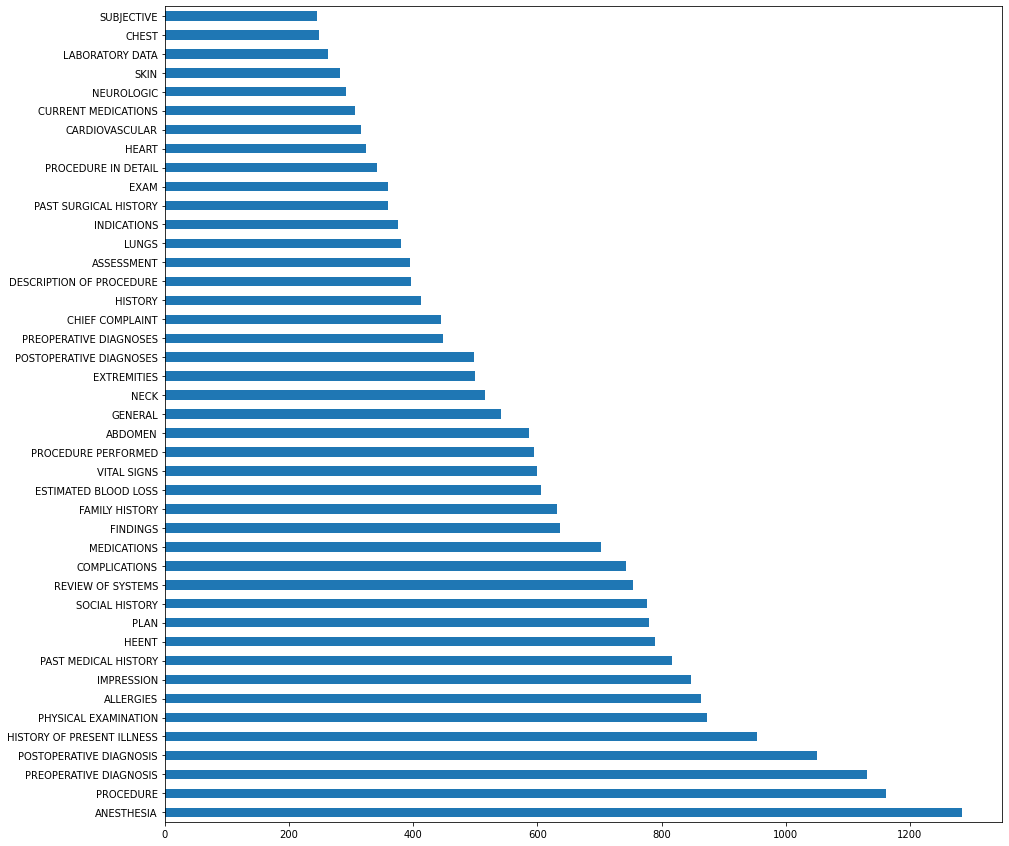

In [9]:
count_sort=data.count().sort_values(ascending=False)
count_number = len([i for i in count_sort if i > 200])
count_sort[3:count_number].plot(kind='barh',figsize=(15,15))

https://www.machinelearningplus.com/nlp/text-summarization-approaches-nlp-example/

## Text Summarization
The length of the original transcription can vary from 11 to 18,425 as strings, previously we just used zero-padding to deal with the length problem, but it may cause the accuracy problem no matter in each model. In this part, we implemented some text summarization method, hoping to filter out some less important words and improve the accuracy. 
## Extractive Text Summarization
It is the traditional method developed first. The main objective is to identify the significant sentences of the text and add them to the summary. You need to note that the summary obtained contains exact sentences from the original text.
### Gensim with TextRank Algorithm
TextRank is an extractive summarization technique. It is based on the concept that words which occur more frequently are significant. Hence, the sentences containing highly frequent words are important.

In [ ]:
data.transcription.str.len().max()

In [ ]:
data.transcription.str.len().min()

In [10]:
original_text=data.iloc[0]['SUBJECTIVE']
print(original_text)

,  This 23-year-old white female presents with complaint of allergies.  She used to have allergies when she lived in Seattle but she thinks they are worse here.  In the past, she has tried Claritin, and Zyrtec.  Both worked for short time but then seemed to lose effectiveness.  She has used Allegra also.  She used that last summer and she began using it again two weeks ago.  It does not appear to be working very well.  She has used over-the-counter sprays but no prescription nasal sprays.  She does have asthma but doest not require daily medication for this and does not think it is flaring up.,


In [11]:
textrank_summary = summarize(original_text,ratio=0.5)
#short_summary1 = summarize(test,ratio=0.3,word_count=30)
print(textrank_summary)

,  This 23-year-old white female presents with complaint of allergies.
She used to have allergies when she lived in Seattle but she thinks they are worse here.
Both worked for short time but then seemed to lose effectiveness.
It does not appear to be working very well.


### LSA (Latent semantic analysis)
Latent Semantic Analysis is a unsupervised learning algorithm that can be used for extractive text summarization. It extracts semantically significant sentences by applying singular value decomposition(SVD) to the matrix of term-document frequency.

In [13]:
# Import the summarizer
from sumy.summarizers.lsa import LsaSummarizer
# Parsing the text string using PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.parsers.plaintext import PlaintextParser
parser=PlaintextParser.from_string(original_text,Tokenizer('english'))
# creating the summarizer
lsa_summarizer=LsaSummarizer()
# pre-define number of sentence=3
lsa_summary= lsa_summarizer(parser.document,3)
# Printing the summary
for sentence in lsa_summary:
    print(sentence)

In the past, she has tried Claritin, and Zyrtec.
Both worked for short time but then seemed to lose effectiveness.
It does not appear to be working very well.


### Luhn
Luhn Summarization algorithm’s approach is based on TF-IDF (Term Frequency-Inverse Document Frequency). It is useful when very low frequent words as well as highly frequent words(stopwords) are both not significant.

In [14]:
# Import the summarizer
from sumy.summarizers.luhn import LuhnSummarizer
#  Creating the summarizer
luhn_summarizer=LuhnSummarizer()
# pre-define number of sentence=3
luhn_summary=luhn_summarizer(parser.document,sentences_count=3)
# Printing the summary
for sentence in luhn_summary:
  print(sentence)

She used to have allergies when she lived in Seattle but she thinks they are worse here.
She has used over-the-counter sprays but no prescription nasal sprays.
She does have asthma but doest not require daily medication for this and does not think it is flaring up.,


### KL-Sum
It selects sentences based on similarity of word distribution as the original text. It aims to lower the KL-divergence criteria. It uses greedy optimization approach and keeps adding sentences till the KL-divergence decreases.

In [15]:
from sumy.summarizers.kl import KLSummarizer
# Instantiating the  KLSummarizer
kl_summarizer=KLSummarizer()
# pre-define number of sentence=3
kl_summary=kl_summarizer(parser.document,sentences_count=3)
# Printing the summary
for sentence in kl_summary:
    print(sentence)

She used to have allergies when she lived in Seattle but she thinks they are worse here.
She has used Allegra also.
She has used over-the-counter sprays but no prescription nasal sprays.


## Abstractive Text Summarization
Abstractive summarization is the new state of art method, which generates new sentences that could best represent the whole text. It is a more advanced method, many advancements keep coming out frequently. The approach is to identify the important sections, interpret the context and reproduce in a new way. This ensures that the core information is conveyed through shortest text possible. Note that here, the sentences in summary are generated, not just extracted from original text. A simple and effective way is through the Huggingface's transformers library. HuggingFace supports state of the art models to implement tasks such as summarization, classification, etc.. Some common models are GPT-2, GPT-3, BERT , OpenAI, GPT, T5.

### T5 Transformers
The T5 model was presented in Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer by Colin Raffel, Noam Shazeer, Adam Roberts, Katherine Lee, Sharan Narang, Michael Matena, Yanqi Zhou, Wei Li, Peter J. Liu.

T5 is an encoder-decoder model pre-trained on a multi-task mixture of unsupervised and supervised tasks and for which each task is converted into a text-to-text format. T5 works well on a variety of tasks out-of-the-box by prepending a different prefix to the input corresponding to each task, e.g., for translation: translate English to German: …, for summarization: summarize: ….


In [16]:
torch.cuda.is_available()

True

In [29]:
from transformers import T5Tokenizer, T5Config, T5ForConditionalGeneration
# Instantiating the model and tokenizer 
device = "cuda:0"
my_model = T5ForConditionalGeneration.from_pretrained('t5-small')
my_model.to(device)
tokenizer = T5Tokenizer.from_pretrained('t5-small')

In [37]:
# Concatenating the word "summarize:" to raw text. T5 transformers performs different tasks by prepending the particular prefix to the input text.
text = "summarize:" + original_text
# encoding the input text
input_ids=tokenizer.encode(text, return_tensors='pt').to(device)
# Generating summary ids
summary_ids = my_model.generate(input_ids,num_beams=5,no_repeat_ngram_size=1,early_stopping=False)
# Decoding the tensor and printing the summary.
t5_summary = tokenizer.decode(summary_ids[0],skip_special_tokens=True)
print(t5_summary)

white female, 23, has complaints of allergies. she used to have allergy when living in Seattle


In [41]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Config

model = T5ForConditionalGeneration.from_pretrained('t5-small')
tokenizer = T5Tokenizer.from_pretrained('t5-small')

text ="""
The US has "passed the peak" on new coronavirus cases, President Donald Trump said and predicted that some states would reopen this month.
The US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths, the highest for any country in the world.
At the daily White House coronavirus briefing on Wednesday, Trump said new guidelines to reopen the country would be announced on Thursday after he speaks to governors.
"We'll be the comeback kids, all of us," he said. "We want to get our country back."
The Trump administration has previously fixed May 1 as a possible date to reopen the world's largest economy, but the president said some states may be able to return to normalcy earlier than that.
You should put your model on the device, which is probably cuda,hen make sure the inputs of the model(input) are on the same device as well.
I am running a BERT model on torch. It's a multi-class sentiment classification task with about 30,000 rows. I have already put everything on cuda, but not sure why I'm getting the following run time error. Here is my code:
The US has "passed the peak" on new coronavirus cases, President Donald Trump said and predicted that some states would reopen this month.
The US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths, the highest for any country in the world.
At the daily White House coronavirus briefing on Wednesday, Trump said new guidelines to reopen the country would be announced on Thursday after he speaks to governors.
"We'll be the comeback kids, all of us," he said. "We want to get our country back."
The Trump administration has previously fixed May 1 as a possible date to reopen the world's largest economy, but the president said some states may be able to return to normalcy earlier than that.
You should put your model on the device, which is probably cuda,hen make sure the inputs of the model(input) are on the same device as well.
I am running a BERT model on torch. It's a multi-class sentiment classification task with about 30,000 rows. I have already put everything on cuda, but not sure why I'm getting the following run time error. Here is my code:
"""


preprocess_text = text.strip().replace("\n","")
t5_prepared_Text = "summarize: "+preprocess_text
print ("original text preprocessed: \n", preprocess_text)

tokenized_text = tokenizer.encode(t5_prepared_Text, return_tensors="pt")


# summmarize 
summary_ids = model.generate(tokenized_text,
                                    num_beams=4,
                                    no_repeat_ngram_size=2,
                                    min_length=30,
                                    max_length=100,
                                    early_stopping=True)

output = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

print ("\n\nSummarized text: \n",output)

Token indices sequence length is longer than the specified maximum sequence length for this model (530 > 512). Running this sequence through the model will result in indexing errors


original text preprocessed: 
 The US has "passed the peak" on new coronavirus cases, President Donald Trump said and predicted that some states would reopen this month.The US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths, the highest for any country in the world.At the daily White House coronavirus briefing on Wednesday, Trump said new guidelines to reopen the country would be announced on Thursday after he speaks to governors."We'll be the comeback kids, all of us," he said. "We want to get our country back."The Trump administration has previously fixed May 1 as a possible date to reopen the world's largest economy, but the president said some states may be able to return to normalcy earlier than that.You should put your model on the device, which is probably cuda,hen make sure the inputs of the model(input) are on the same device as well.I am running a BERT model on torch. It's a multi-class sentiment classification task with about 30,000 rows. I have already put e

In [49]:
nltk_tokens = nltk.word_tokenize(text)
tokenized_text.shape

torch.Size([1, 530])

In [44]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/hzhuge/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### BART Transformers
The Bart model was proposed in BART: Denoising Sequence-to-Sequence Pre-training for Natural Language Generation, Translation, and Comprehension by Mike Lewis, Yinhan Liu, Naman Goyal, Marjan Ghazvininejad, Abdelrahman Mohamed, Omer Levy, Ves Stoyanov and Luke Zettlemoyer on 29 Oct, 2019. According to the abstract,
- Bart uses a standard seq2seq/machine translation architecture with a bidirectional encoder (like BERT) and a left-to-right decoder (like GPT).

- The pretraining task involves randomly shuffling the order of the original sentences and a novel in-filling scheme, where spans of text are replaced with a single mask token.

- BART is particularly effective when fine tuned for text generation but also works well for comprehension tasks. It matches the performance of RoBERTa with comparable training resources on GLUE and SQuAD, achieves new state-of-the-art results on a range of abstractive dialogue, question answering, and summarization tasks, with gains of up to 6 ROUGE.

In [23]:
# Importing the model
from transformers import BartForConditionalGeneration, BartTokenizer, BartConfig
# Loading the model and tokenizer for bart-large-cnn
tokenizer=BartTokenizer.from_pretrained('facebook/bart-large-cnn')
model=BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')


Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

In [26]:
# Encoding the inputs and passing them to model.generate()
inputs = tokenizer.batch_encode_plus([original_text],return_tensors='pt')
summary_ids = model.generate(inputs['input_ids'], num_beams=4,
                                    no_repeat_ngram_size=2,early_stopping=False)
# Decoding and printing the summary
bart_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
print(bart_summary)

23-year-old white female presents with complaint of allergies. She used to have allergies when she lived in Seattle but she thinks they are worse here. Has tried Claritin, and Zyrtec. Both worked for short time but then seemed to lose effectiveness. Does have asthma but doest not require daily medication for this and does not think it is flaring up.


In [18]:
original_text=data.iloc[0]['SUBJECTIVE']
original_text

',  This 23-year-old white female presents with complaint of allergies.  She used to have allergies when she lived in Seattle but she thinks they are worse here.  In the past, she has tried Claritin, and Zyrtec.  Both worked for short time but then seemed to lose effectiveness.  She has used Allegra also.  She used that last summer and she began using it again two weeks ago.  It does not appear to be working very well.  She has used over-the-counter sprays but no prescription nasal sprays.  She does have asthma but doest not require daily medication for this and does not think it is flaring up.,'

### GPT-2 Transformers ??? why not working
GPT-2 transformer is another major player in text summarization, introduced by OpenAI.

In [50]:
# Importing model and tokenizer
from transformers import GPT2Tokenizer,GPT2LMHeadModel

# Instantiating the model and tokenizer with gpt-2
tokenizer=GPT2Tokenizer.from_pretrained('gpt2')
model=GPT2LMHeadModel.from_pretrained('gpt2',pad_token_id=tokenizer.eos_token_id)

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

In [52]:
model.config.max_length=1000
# Encoding text to get input ids & pass them to model.generate()
inputs=tokenizer.batch_encode_plus([original_text],return_tensors='pt')
summary_ids=model.generate(inputs['input_ids'],early_stopping=True)
# Decoding and printing summary

GPT_summary=tokenizer.decode(summary_ids[0],skip_special_tokens=True)
print(GPT_summary)

,  This 23-year-old white female presents with complaint of allergies.  She used to have allergies when she lived in Seattle but she thinks they are worse here.  In the past, she has tried Claritin, and Zyrtec.  Both worked for short time but then seemed to lose effectiveness.  She has used Allegra also.  She used that last summer and she began using it again two weeks ago.  It does not appear to be working very well.  She has used over-the-counter sprays but no prescription nasal sprays.  She does have asthma but doest not require daily medication for this and does not think it is flaring up.,  This 23-year-old white female presents with complaint of allergies.  She used to have allergies when she lived in Seattle but she thinks they are worse here.  In the past, she has tried Claritin, and Zyrtec.  Both worked for short time but then seemed to lose effectiveness.  She has used Allegra also.  She used that last summer and she began using it again two weeks ago.  It does not appear to 

### Overall Pipeline
The result of abstractive text summarizstion is not that good, due to the existence of rare medical words, but it might miss some importance information just using the extractive text summarization, moreover, the t5-small model has the length limitation of 512 words. So we mixed the TextRank Algorithm and T5 Transformers to build up the following pipeline.
<ol>
<li>Divide the 'transcription' column based on Upper case keywords.</li>
<li>If the content of keyword is greater than 512, use text rand to extract the information with suitable ratio, reduce the size to 512.</li>
<li>Summarize the text if the len of the content is greater than 50 for each keyword by T5.</li>
<li>Put the summarized content together with keywords as new column 'transcript_T5'.</li>
<li>Record the length of 'transcript' and 'transcript_T5' for further comparison.</li>
</ol>

In [53]:
from transformers import T5Tokenizer, T5Config, T5ForConditionalGeneration
# Instantiating the model and tokenizer 
device = "cuda:0"
my_model = T5ForConditionalGeneration.from_pretrained('t5-small')
my_model.to(device)
tokenizer = T5Tokenizer.from_pretrained('t5-small')


In [63]:
# Concatenating the word "summarize:" to raw text. T5 transformers performs different tasks by prepending the particular prefix to the input text.
text = "summarize:" + original_text
# encoding the input text
input_ids=tokenizer.encode(text, return_tensors='pt').to(device)
# Generating summary ids
summary_ids = my_model.generate(input_ids,num_beams=5,no_repeat_ngram_size=1,early_stopping=False)
# Decoding the tensor and printing the summary.
t5_summary = tokenizer.decode(summary_ids[0],skip_special_tokens=True)
print(t5_summary)

Her throat was mildly erythematous without exudate. Nasal mucosa was ery thematous and swollen. Only clear drainage was seen. TMs were clear. She was admitted to the hospital with a sore throat and a swollen throat.


In [ ]:
textrank_summary = summarize(original_text,ratio=0.5)
#short_summary1 = summarize(test,ratio=0.3,word_count=30)
print(textrank_summary)

In [64]:
regex = r"\b([A-Z]+(?:[^\S\r\n]+[A-Z]+)*):"
# translator_c = str.maketrans(string.punctuation, ' '*len(string.punctuation))
# data['transcription_clear']=data['transcription'].apply(lambda x: ' '.join([i for i in str(x).lower().
#                                             translate(translator_c).split(' ') if i.isalpha()]))
for index,data_row in data.iterrows():
    transcrption_summary=""
    temp_split=re.split(regex, data_row['transcription'])
    for odd, t in enumerate(temp_split):
        if (odd % 2) != 0:
#            translator_c = str.maketrans(string.punctuation, ' '*len(string.punctuation))
#             temp_modify=temp_split[odd+1].apply(lambda x: ' '.join([i for i in str(x).lower().
#                                             translate(translator_c).split(' ') if i.isalpha()]))
#            data.at[index,t]=temp_split[odd+1]
            transcrption_summary+=temp_split[odd]
            transcrption_summary+=':'
        # number of tokens
            nltk_tokens = len(nltk.word_tokenize(temp_split[odd+1]))
        # The maximum sequence length that this model might ever be used with is 1024
            if nltk_tokens>50 and nltk_tokens<512:
                text = "summarize:" + temp_split[odd+1]
                # encoding the input text
                input_ids=tokenizer.encode(text, return_tensors='pt').to(device)
 # Generating summary ids
                summary_ids = my_model.generate(input_ids,num_beams=5,no_repeat_ngram_size=2,early_stopping=False)
# Decoding the tensor and printing the summary.
                t5_summary = tokenizer.decode(summary_ids[0],skip_special_tokens=True)
                transcrption_summary+=t5_summary
                transcrption_summary+='.,'
            elif nltk_tokens>=512:
                    # text rank extracts information to size around 1024, then use BART
                ratio_temp=512/nltk_tokens
                textrank_summary = summarize(temp_split[odd+1],ratio=ratio_temp)
                
                text = "summarize:" + textrank_summary
                # encoding the input text
                input_ids=tokenizer.encode(text, return_tensors='pt').to(device)
 # Generating summary ids
                summary_ids = my_model.generate(input_ids,num_beams=5,no_repeat_ngram_size=1,early_stopping=False)
# Decoding the tensor and printing the summary.
                t5_summary = tokenizer.decode(summary_ids[0],skip_special_tokens=True)
                transcrption_summary+=t5_summary
                transcrption_summary+='.,'
            else:
                transcrption_summary+=temp_split[odd+1]
                
    print(index)
    data.at[index,'transcription_T5']=transcrption_summary
    data.at[index,'transcription_len']=len(data.at[index,'transcription'])
    data.at[index,'transcription_T5_len']=len(data.at[index,'transcription_T5'])
data.to_csv(r'summary_T5.csv', index = False)

0
1
2
3
4


Token indices sequence length is longer than the specified maximum sequence length for this model (539 > 512). Running this sequence through the model will result in indexing errors


5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42


Token indices sequence length is longer than the specified maximum sequence length for this model (563 > 512). Running this sequence through the model will result in indexing errors


43
44
45
46


Token indices sequence length is longer than the specified maximum sequence length for this model (574 > 512). Running this sequence through the model will result in indexing errors


47


Token indices sequence length is longer than the specified maximum sequence length for this model (572 > 512). Running this sequence through the model will result in indexing errors


48
49


Token indices sequence length is longer than the specified maximum sequence length for this model (553 > 512). Running this sequence through the model will result in indexing errors


50


Token indices sequence length is longer than the specified maximum sequence length for this model (526 > 512). Running this sequence through the model will result in indexing errors


51
52


Token indices sequence length is longer than the specified maximum sequence length for this model (528 > 512). Running this sequence through the model will result in indexing errors


53
54
55
56
57
58
59
60


Token indices sequence length is longer than the specified maximum sequence length for this model (626 > 512). Running this sequence through the model will result in indexing errors


61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76


Token indices sequence length is longer than the specified maximum sequence length for this model (526 > 512). Running this sequence through the model will result in indexing errors


77
78
79
80
81
82


Token indices sequence length is longer than the specified maximum sequence length for this model (550 > 512). Running this sequence through the model will result in indexing errors


83
84
85
86


Token indices sequence length is longer than the specified maximum sequence length for this model (570 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (579 > 512). Running this sequence through the model will result in indexing errors


87
88


Token indices sequence length is longer than the specified maximum sequence length for this model (571 > 512). Running this sequence through the model will result in indexing errors


89


Token indices sequence length is longer than the specified maximum sequence length for this model (530 > 512). Running this sequence through the model will result in indexing errors


90
91
92
93
94
95
96
98
99
100
101
102
103
104
105


Token indices sequence length is longer than the specified maximum sequence length for this model (600 > 512). Running this sequence through the model will result in indexing errors


106
107


Token indices sequence length is longer than the specified maximum sequence length for this model (553 > 512). Running this sequence through the model will result in indexing errors


108
109


Token indices sequence length is longer than the specified maximum sequence length for this model (648 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (530 > 512). Running this sequence through the model will result in indexing errors


110


Token indices sequence length is longer than the specified maximum sequence length for this model (537 > 512). Running this sequence through the model will result in indexing errors


111
112
113
114
115
117
118
119
120
121
122
123
124
125
126
127
128
129


Token indices sequence length is longer than the specified maximum sequence length for this model (593 > 512). Running this sequence through the model will result in indexing errors


130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148


Token indices sequence length is longer than the specified maximum sequence length for this model (653 > 512). Running this sequence through the model will result in indexing errors


149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173


Token indices sequence length is longer than the specified maximum sequence length for this model (531 > 512). Running this sequence through the model will result in indexing errors


174
175
176
177


Token indices sequence length is longer than the specified maximum sequence length for this model (589 > 512). Running this sequence through the model will result in indexing errors


178
179
180
181
182
183
184
185
186
187
188
189
190


Token indices sequence length is longer than the specified maximum sequence length for this model (541 > 512). Running this sequence through the model will result in indexing errors


191
192
193
194
195
196
197
198
199
200
201
202


Token indices sequence length is longer than the specified maximum sequence length for this model (633 > 512). Running this sequence through the model will result in indexing errors


203
204
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223


Token indices sequence length is longer than the specified maximum sequence length for this model (574 > 512). Running this sequence through the model will result in indexing errors


224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246


Token indices sequence length is longer than the specified maximum sequence length for this model (578 > 512). Running this sequence through the model will result in indexing errors


247
248
249


Token indices sequence length is longer than the specified maximum sequence length for this model (590 > 512). Running this sequence through the model will result in indexing errors


250
251
252
253


Token indices sequence length is longer than the specified maximum sequence length for this model (531 > 512). Running this sequence through the model will result in indexing errors


254
255
256


Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors


257
258
259


Token indices sequence length is longer than the specified maximum sequence length for this model (559 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (535 > 512). Running this sequence through the model will result in indexing errors


260
261
262


Token indices sequence length is longer than the specified maximum sequence length for this model (586 > 512). Running this sequence through the model will result in indexing errors


264
265
266
267
268


Token indices sequence length is longer than the specified maximum sequence length for this model (608 > 512). Running this sequence through the model will result in indexing errors


269
270
271
272
273


Token indices sequence length is longer than the specified maximum sequence length for this model (513 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (657 > 512). Running this sequence through the model will result in indexing errors


274
275
276


Token indices sequence length is longer than the specified maximum sequence length for this model (573 > 512). Running this sequence through the model will result in indexing errors


277
278
279
280
281
282


Token indices sequence length is longer than the specified maximum sequence length for this model (578 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (541 > 512). Running this sequence through the model will result in indexing errors


283
284
285
286


Token indices sequence length is longer than the specified maximum sequence length for this model (586 > 512). Running this sequence through the model will result in indexing errors


287
288
289
290
291
292
293
294
295


Token indices sequence length is longer than the specified maximum sequence length for this model (570 > 512). Running this sequence through the model will result in indexing errors


296
297


Token indices sequence length is longer than the specified maximum sequence length for this model (531 > 512). Running this sequence through the model will result in indexing errors


298
299


Token indices sequence length is longer than the specified maximum sequence length for this model (587 > 512). Running this sequence through the model will result in indexing errors


300
301


Token indices sequence length is longer than the specified maximum sequence length for this model (689 > 512). Running this sequence through the model will result in indexing errors


302


Token indices sequence length is longer than the specified maximum sequence length for this model (544 > 512). Running this sequence through the model will result in indexing errors


303


Token indices sequence length is longer than the specified maximum sequence length for this model (579 > 512). Running this sequence through the model will result in indexing errors


304


Token indices sequence length is longer than the specified maximum sequence length for this model (662 > 512). Running this sequence through the model will result in indexing errors


305
306


Token indices sequence length is longer than the specified maximum sequence length for this model (587 > 512). Running this sequence through the model will result in indexing errors


307
308


Token indices sequence length is longer than the specified maximum sequence length for this model (529 > 512). Running this sequence through the model will result in indexing errors


309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329


Token indices sequence length is longer than the specified maximum sequence length for this model (526 > 512). Running this sequence through the model will result in indexing errors


330
331


Token indices sequence length is longer than the specified maximum sequence length for this model (560 > 512). Running this sequence through the model will result in indexing errors


332
333
334
335
336
337
338
339
340
341
342
343
344


Token indices sequence length is longer than the specified maximum sequence length for this model (532 > 512). Running this sequence through the model will result in indexing errors


345


Token indices sequence length is longer than the specified maximum sequence length for this model (518 > 512). Running this sequence through the model will result in indexing errors


346
347
348
349
350


Token indices sequence length is longer than the specified maximum sequence length for this model (709 > 512). Running this sequence through the model will result in indexing errors


351
352
353


Token indices sequence length is longer than the specified maximum sequence length for this model (565 > 512). Running this sequence through the model will result in indexing errors


354


Token indices sequence length is longer than the specified maximum sequence length for this model (599 > 512). Running this sequence through the model will result in indexing errors


355
356
357


Token indices sequence length is longer than the specified maximum sequence length for this model (547 > 512). Running this sequence through the model will result in indexing errors


358
359
360
361
362


Token indices sequence length is longer than the specified maximum sequence length for this model (564 > 512). Running this sequence through the model will result in indexing errors


363
364
365
366
367


Token indices sequence length is longer than the specified maximum sequence length for this model (556 > 512). Running this sequence through the model will result in indexing errors


368


Token indices sequence length is longer than the specified maximum sequence length for this model (563 > 512). Running this sequence through the model will result in indexing errors


369
370


Token indices sequence length is longer than the specified maximum sequence length for this model (532 > 512). Running this sequence through the model will result in indexing errors


371
372
373
374
375
376


Token indices sequence length is longer than the specified maximum sequence length for this model (525 > 512). Running this sequence through the model will result in indexing errors


377
378


Token indices sequence length is longer than the specified maximum sequence length for this model (542 > 512). Running this sequence through the model will result in indexing errors


379
380
381
382
383
384
385
386
387
388
389
390
391


Token indices sequence length is longer than the specified maximum sequence length for this model (544 > 512). Running this sequence through the model will result in indexing errors


392
393
394


Token indices sequence length is longer than the specified maximum sequence length for this model (574 > 512). Running this sequence through the model will result in indexing errors


395
396
397
398


Token indices sequence length is longer than the specified maximum sequence length for this model (528 > 512). Running this sequence through the model will result in indexing errors


399
400
401
402


Token indices sequence length is longer than the specified maximum sequence length for this model (572 > 512). Running this sequence through the model will result in indexing errors


403
404


Token indices sequence length is longer than the specified maximum sequence length for this model (526 > 512). Running this sequence through the model will result in indexing errors


405


Token indices sequence length is longer than the specified maximum sequence length for this model (553 > 512). Running this sequence through the model will result in indexing errors


406


Token indices sequence length is longer than the specified maximum sequence length for this model (575 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (642 > 512). Running this sequence through the model will result in indexing errors


407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423


Token indices sequence length is longer than the specified maximum sequence length for this model (581 > 512). Running this sequence through the model will result in indexing errors


424
425
426
427
428
429
430
431
432
433
434
435
436


Token indices sequence length is longer than the specified maximum sequence length for this model (522 > 512). Running this sequence through the model will result in indexing errors


437
438
439
440
441
442
443
444
445
446
447
448
449
450
451


Token indices sequence length is longer than the specified maximum sequence length for this model (626 > 512). Running this sequence through the model will result in indexing errors


452
453
454


Token indices sequence length is longer than the specified maximum sequence length for this model (515 > 512). Running this sequence through the model will result in indexing errors


455
456
457
458
460


Token indices sequence length is longer than the specified maximum sequence length for this model (711 > 512). Running this sequence through the model will result in indexing errors


461
462
463
464
465


Token indices sequence length is longer than the specified maximum sequence length for this model (513 > 512). Running this sequence through the model will result in indexing errors


466
467
468
469
470
471
472
473
474
475


Token indices sequence length is longer than the specified maximum sequence length for this model (544 > 512). Running this sequence through the model will result in indexing errors


476
477
478


Token indices sequence length is longer than the specified maximum sequence length for this model (536 > 512). Running this sequence through the model will result in indexing errors


479
480
481
482
483
484


Token indices sequence length is longer than the specified maximum sequence length for this model (655 > 512). Running this sequence through the model will result in indexing errors


485
486
487


Token indices sequence length is longer than the specified maximum sequence length for this model (521 > 512). Running this sequence through the model will result in indexing errors


488
489
490
491
492
493
494


Token indices sequence length is longer than the specified maximum sequence length for this model (598 > 512). Running this sequence through the model will result in indexing errors


495


Token indices sequence length is longer than the specified maximum sequence length for this model (526 > 512). Running this sequence through the model will result in indexing errors


496


Token indices sequence length is longer than the specified maximum sequence length for this model (535 > 512). Running this sequence through the model will result in indexing errors


497
498
499
500
501
502
503
504


Token indices sequence length is longer than the specified maximum sequence length for this model (570 > 512). Running this sequence through the model will result in indexing errors


505
506
507
508


Token indices sequence length is longer than the specified maximum sequence length for this model (618 > 512). Running this sequence through the model will result in indexing errors


509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524


Token indices sequence length is longer than the specified maximum sequence length for this model (572 > 512). Running this sequence through the model will result in indexing errors


525


Token indices sequence length is longer than the specified maximum sequence length for this model (674 > 512). Running this sequence through the model will result in indexing errors


526
527
528
529
530


Token indices sequence length is longer than the specified maximum sequence length for this model (660 > 512). Running this sequence through the model will result in indexing errors


531
532
533
534
535
536
537
538
539
540
541
542


Token indices sequence length is longer than the specified maximum sequence length for this model (550 > 512). Running this sequence through the model will result in indexing errors


543
544


Token indices sequence length is longer than the specified maximum sequence length for this model (537 > 512). Running this sequence through the model will result in indexing errors


545
546
547


Token indices sequence length is longer than the specified maximum sequence length for this model (576 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (531 > 512). Running this sequence through the model will result in indexing errors


548
549
550
551
552
553
554
555
556
557
558
559


Token indices sequence length is longer than the specified maximum sequence length for this model (523 > 512). Running this sequence through the model will result in indexing errors


560


Token indices sequence length is longer than the specified maximum sequence length for this model (549 > 512). Running this sequence through the model will result in indexing errors


561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578


Token indices sequence length is longer than the specified maximum sequence length for this model (544 > 512). Running this sequence through the model will result in indexing errors


579
580


Token indices sequence length is longer than the specified maximum sequence length for this model (621 > 512). Running this sequence through the model will result in indexing errors


581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601


Token indices sequence length is longer than the specified maximum sequence length for this model (574 > 512). Running this sequence through the model will result in indexing errors


602
603
604
605
606
607
608
609
610
611
612
613
614
615


Token indices sequence length is longer than the specified maximum sequence length for this model (681 > 512). Running this sequence through the model will result in indexing errors


616
617


Token indices sequence length is longer than the specified maximum sequence length for this model (679 > 512). Running this sequence through the model will result in indexing errors


618
619
620
621
623


Token indices sequence length is longer than the specified maximum sequence length for this model (579 > 512). Running this sequence through the model will result in indexing errors


624
625
626


Token indices sequence length is longer than the specified maximum sequence length for this model (529 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (571 > 512). Running this sequence through the model will result in indexing errors


627
629


Token indices sequence length is longer than the specified maximum sequence length for this model (539 > 512). Running this sequence through the model will result in indexing errors


630


Token indices sequence length is longer than the specified maximum sequence length for this model (543 > 512). Running this sequence through the model will result in indexing errors


631


Token indices sequence length is longer than the specified maximum sequence length for this model (542 > 512). Running this sequence through the model will result in indexing errors


632
633


Token indices sequence length is longer than the specified maximum sequence length for this model (546 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (598 > 512). Running this sequence through the model will result in indexing errors


634


Token indices sequence length is longer than the specified maximum sequence length for this model (599 > 512). Running this sequence through the model will result in indexing errors


635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650


Token indices sequence length is longer than the specified maximum sequence length for this model (573 > 512). Running this sequence through the model will result in indexing errors


651
652
653
654
655
656
657
658
659


Token indices sequence length is longer than the specified maximum sequence length for this model (641 > 512). Running this sequence through the model will result in indexing errors


660
661
662
663
664


Token indices sequence length is longer than the specified maximum sequence length for this model (543 > 512). Running this sequence through the model will result in indexing errors


665
666


Token indices sequence length is longer than the specified maximum sequence length for this model (534 > 512). Running this sequence through the model will result in indexing errors


667
668
669
670
671
672
673
674


Token indices sequence length is longer than the specified maximum sequence length for this model (565 > 512). Running this sequence through the model will result in indexing errors


675


Token indices sequence length is longer than the specified maximum sequence length for this model (532 > 512). Running this sequence through the model will result in indexing errors


676
677
678
679
681


Token indices sequence length is longer than the specified maximum sequence length for this model (530 > 512). Running this sequence through the model will result in indexing errors


682
683
684
685
686
687
688
689
690
691
692
693
694
695
696


Token indices sequence length is longer than the specified maximum sequence length for this model (600 > 512). Running this sequence through the model will result in indexing errors


697


Token indices sequence length is longer than the specified maximum sequence length for this model (576 > 512). Running this sequence through the model will result in indexing errors


698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713


Token indices sequence length is longer than the specified maximum sequence length for this model (574 > 512). Running this sequence through the model will result in indexing errors


714
715


Token indices sequence length is longer than the specified maximum sequence length for this model (553 > 512). Running this sequence through the model will result in indexing errors


716
717
718


Token indices sequence length is longer than the specified maximum sequence length for this model (648 > 512). Running this sequence through the model will result in indexing errors


719
720


Token indices sequence length is longer than the specified maximum sequence length for this model (530 > 512). Running this sequence through the model will result in indexing errors


721
722
723


Token indices sequence length is longer than the specified maximum sequence length for this model (537 > 512). Running this sequence through the model will result in indexing errors


724
725
726
727
728
730
731
732


Token indices sequence length is longer than the specified maximum sequence length for this model (575 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (514 > 512). Running this sequence through the model will result in indexing errors


733
734
735
736


Token indices sequence length is longer than the specified maximum sequence length for this model (582 > 512). Running this sequence through the model will result in indexing errors


737
738
739


Token indices sequence length is longer than the specified maximum sequence length for this model (539 > 512). Running this sequence through the model will result in indexing errors


740


Token indices sequence length is longer than the specified maximum sequence length for this model (530 > 512). Running this sequence through the model will result in indexing errors


741
742


Token indices sequence length is longer than the specified maximum sequence length for this model (513 > 512). Running this sequence through the model will result in indexing errors


743
744
745


Token indices sequence length is longer than the specified maximum sequence length for this model (531 > 512). Running this sequence through the model will result in indexing errors


746
747
748
749
750
751


Token indices sequence length is longer than the specified maximum sequence length for this model (552 > 512). Running this sequence through the model will result in indexing errors


752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779


Token indices sequence length is longer than the specified maximum sequence length for this model (541 > 512). Running this sequence through the model will result in indexing errors


780
781
782
783
784
785
786


Token indices sequence length is longer than the specified maximum sequence length for this model (558 > 512). Running this sequence through the model will result in indexing errors


787
788
789


Token indices sequence length is longer than the specified maximum sequence length for this model (534 > 512). Running this sequence through the model will result in indexing errors


790
791
792
793
794


Token indices sequence length is longer than the specified maximum sequence length for this model (598 > 512). Running this sequence through the model will result in indexing errors


795
796
797
798
799
800
801
802
803
804
805
806
807
808
809


Token indices sequence length is longer than the specified maximum sequence length for this model (529 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors


810
811
812


Token indices sequence length is longer than the specified maximum sequence length for this model (555 > 512). Running this sequence through the model will result in indexing errors


813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864


Token indices sequence length is longer than the specified maximum sequence length for this model (587 > 512). Running this sequence through the model will result in indexing errors


865
866
867
868
869
870
872
873
874
875
876
877
878
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896


Token indices sequence length is longer than the specified maximum sequence length for this model (573 > 512). Running this sequence through the model will result in indexing errors


897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915


Token indices sequence length is longer than the specified maximum sequence length for this model (537 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (574 > 512). Running this sequence through the model will result in indexing errors


916


Token indices sequence length is longer than the specified maximum sequence length for this model (612 > 512). Running this sequence through the model will result in indexing errors


917
918
919
920


Token indices sequence length is longer than the specified maximum sequence length for this model (648 > 512). Running this sequence through the model will result in indexing errors


921
922
923


Token indices sequence length is longer than the specified maximum sequence length for this model (537 > 512). Running this sequence through the model will result in indexing errors


924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942


Token indices sequence length is longer than the specified maximum sequence length for this model (653 > 512). Running this sequence through the model will result in indexing errors


943
944
945
946
947
948
949
950
951


Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors


952
953
954
955
956
957


Token indices sequence length is longer than the specified maximum sequence length for this model (829 > 512). Running this sequence through the model will result in indexing errors


958


Token indices sequence length is longer than the specified maximum sequence length for this model (528 > 512). Running this sequence through the model will result in indexing errors


959
960


Token indices sequence length is longer than the specified maximum sequence length for this model (588 > 512). Running this sequence through the model will result in indexing errors


961
962


Token indices sequence length is longer than the specified maximum sequence length for this model (549 > 512). Running this sequence through the model will result in indexing errors


963


Token indices sequence length is longer than the specified maximum sequence length for this model (522 > 512). Running this sequence through the model will result in indexing errors


964
965
966
967
968
969
970
971
972
973
974
975
976


Token indices sequence length is longer than the specified maximum sequence length for this model (515 > 512). Running this sequence through the model will result in indexing errors


977
978
979
980
981
982
986
988
989
990
991
992
993
994
995
996
997
998
999
1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012


Token indices sequence length is longer than the specified maximum sequence length for this model (555 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (518 > 512). Running this sequence through the model will result in indexing errors


1013
1014
1015
1016
1018
1019


Token indices sequence length is longer than the specified maximum sequence length for this model (627 > 512). Running this sequence through the model will result in indexing errors


1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035


Token indices sequence length is longer than the specified maximum sequence length for this model (548 > 512). Running this sequence through the model will result in indexing errors


1036
1037
1038
1039
1040
1041


Token indices sequence length is longer than the specified maximum sequence length for this model (589 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (523 > 512). Running this sequence through the model will result in indexing errors


1042
1043
1044
1045


Token indices sequence length is longer than the specified maximum sequence length for this model (536 > 512). Running this sequence through the model will result in indexing errors


1046
1047
1048
1049
1050
1051
1052


Token indices sequence length is longer than the specified maximum sequence length for this model (557 > 512). Running this sequence through the model will result in indexing errors


1053


Token indices sequence length is longer than the specified maximum sequence length for this model (517 > 512). Running this sequence through the model will result in indexing errors


1054
1056


Token indices sequence length is longer than the specified maximum sequence length for this model (553 > 512). Running this sequence through the model will result in indexing errors


1057
1058
1059
1060
1061
1062


Token indices sequence length is longer than the specified maximum sequence length for this model (539 > 512). Running this sequence through the model will result in indexing errors


1063
1064
1065
1066
1067


Token indices sequence length is longer than the specified maximum sequence length for this model (528 > 512). Running this sequence through the model will result in indexing errors


1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078


Token indices sequence length is longer than the specified maximum sequence length for this model (687 > 512). Running this sequence through the model will result in indexing errors


1079
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089


Token indices sequence length is longer than the specified maximum sequence length for this model (524 > 512). Running this sequence through the model will result in indexing errors


1090
1091
1092
1093
1094
1095


Token indices sequence length is longer than the specified maximum sequence length for this model (621 > 512). Running this sequence through the model will result in indexing errors


1096
1097
1098
1099
1100


Token indices sequence length is longer than the specified maximum sequence length for this model (520 > 512). Running this sequence through the model will result in indexing errors


1101
1102
1103
1104
1105
1106
1107
1108
1109
1110


Token indices sequence length is longer than the specified maximum sequence length for this model (553 > 512). Running this sequence through the model will result in indexing errors


1111
1112
1113
1114


Token indices sequence length is longer than the specified maximum sequence length for this model (676 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (588 > 512). Running this sequence through the model will result in indexing errors


1115
1116


Token indices sequence length is longer than the specified maximum sequence length for this model (581 > 512). Running this sequence through the model will result in indexing errors


1117


Token indices sequence length is longer than the specified maximum sequence length for this model (666 > 512). Running this sequence through the model will result in indexing errors


1118
1119


Token indices sequence length is longer than the specified maximum sequence length for this model (555 > 512). Running this sequence through the model will result in indexing errors


1120
1121
1122
1123


Token indices sequence length is longer than the specified maximum sequence length for this model (553 > 512). Running this sequence through the model will result in indexing errors


1124
1125


Token indices sequence length is longer than the specified maximum sequence length for this model (615 > 512). Running this sequence through the model will result in indexing errors


1126


Token indices sequence length is longer than the specified maximum sequence length for this model (653 > 512). Running this sequence through the model will result in indexing errors


1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137
1138
1139
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149
1150
1151
1152
1153
1154
1155
1156
1157
1158
1159
1160
1161
1162
1163
1164


Token indices sequence length is longer than the specified maximum sequence length for this model (583 > 512). Running this sequence through the model will result in indexing errors


1165
1166
1167
1168
1169
1170
1171
1172


Token indices sequence length is longer than the specified maximum sequence length for this model (525 > 512). Running this sequence through the model will result in indexing errors


1173
1174
1175
1176
1177
1178
1179


Token indices sequence length is longer than the specified maximum sequence length for this model (534 > 512). Running this sequence through the model will result in indexing errors


1180
1181
1182


Token indices sequence length is longer than the specified maximum sequence length for this model (519 > 512). Running this sequence through the model will result in indexing errors


1183
1184
1185
1186
1187
1188
1189
1190
1191
1192
1193
1194


Token indices sequence length is longer than the specified maximum sequence length for this model (603 > 512). Running this sequence through the model will result in indexing errors


1195
1196


Token indices sequence length is longer than the specified maximum sequence length for this model (523 > 512). Running this sequence through the model will result in indexing errors


1197
1198


Token indices sequence length is longer than the specified maximum sequence length for this model (612 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (539 > 512). Running this sequence through the model will result in indexing errors


1199


Token indices sequence length is longer than the specified maximum sequence length for this model (665 > 512). Running this sequence through the model will result in indexing errors


1200
1201
1202
1203
1204


Token indices sequence length is longer than the specified maximum sequence length for this model (602 > 512). Running this sequence through the model will result in indexing errors


1205


Token indices sequence length is longer than the specified maximum sequence length for this model (513 > 512). Running this sequence through the model will result in indexing errors


1206
1207
1208
1209
1210
1211
1212
1213


Token indices sequence length is longer than the specified maximum sequence length for this model (654 > 512). Running this sequence through the model will result in indexing errors


1214


Token indices sequence length is longer than the specified maximum sequence length for this model (522 > 512). Running this sequence through the model will result in indexing errors


1215
1216


Token indices sequence length is longer than the specified maximum sequence length for this model (568 > 512). Running this sequence through the model will result in indexing errors


1217


Token indices sequence length is longer than the specified maximum sequence length for this model (534 > 512). Running this sequence through the model will result in indexing errors


1218
1219
1220
1221
1222
1223
1224
1225


Token indices sequence length is longer than the specified maximum sequence length for this model (638 > 512). Running this sequence through the model will result in indexing errors


1226


Token indices sequence length is longer than the specified maximum sequence length for this model (531 > 512). Running this sequence through the model will result in indexing errors


1227
1228
1229
1230
1231


Token indices sequence length is longer than the specified maximum sequence length for this model (622 > 512). Running this sequence through the model will result in indexing errors


1232
1233
1234
1235
1236
1237


Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors


1238
1239
1240
1241


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


1242
1243


Token indices sequence length is longer than the specified maximum sequence length for this model (548 > 512). Running this sequence through the model will result in indexing errors


1244
1245
1246
1247


Token indices sequence length is longer than the specified maximum sequence length for this model (561 > 512). Running this sequence through the model will result in indexing errors


1248
1249


Token indices sequence length is longer than the specified maximum sequence length for this model (541 > 512). Running this sequence through the model will result in indexing errors


1250


Token indices sequence length is longer than the specified maximum sequence length for this model (515 > 512). Running this sequence through the model will result in indexing errors


1251
1252
1253
1254
1255
1256
1257
1258
1259


Token indices sequence length is longer than the specified maximum sequence length for this model (550 > 512). Running this sequence through the model will result in indexing errors


1260
1261


Token indices sequence length is longer than the specified maximum sequence length for this model (598 > 512). Running this sequence through the model will result in indexing errors


1262
1263
1264
1265


Token indices sequence length is longer than the specified maximum sequence length for this model (571 > 512). Running this sequence through the model will result in indexing errors


1266


Token indices sequence length is longer than the specified maximum sequence length for this model (529 > 512). Running this sequence through the model will result in indexing errors


1267
1268


Token indices sequence length is longer than the specified maximum sequence length for this model (636 > 512). Running this sequence through the model will result in indexing errors


1269
1270
1271
1272
1273
1274
1275
1276
1277
1278
1279
1280
1281
1282
1283
1284
1285
1286
1287
1288
1289
1290
1291
1292
1293
1294
1295
1296
1297
1298
1299
1300
1301
1302
1303
1304
1305
1306
1307
1308
1309
1310
1311
1312
1313
1314
1315
1316
1317
1318
1319
1320
1321
1322
1323
1324
1325
1326
1327
1328
1329
1330
1331
1332
1333
1334
1335
1336
1337
1338
1339
1340
1341
1342
1343
1344
1345
1346
1347
1348
1349
1350
1351
1352
1353
1354
1355
1356
1357
1358
1359
1360
1361
1362
1363
1364
1365
1366
1367
1368
1369
1370
1371
1372
1373
1374
1375
1376
1377
1378
1379
1380
1381
1382
1383
1384
1385
1386
1387
1388
1389
1390
1391
1392
1393
1394
1395
1396
1397
1398
1399
1400
1401
1402
1403
1404
1405
1406
1407
1408
1409
1410
1411
1412
1413
1414
1415
1416
1417
1418
1419
1420
1421
1422
1423
1424
1425
1426
1427
1428
1429
1430
1431
1432
1433
1434
1435
1436
1437
1438
1439
1440
1441
1442
1443
1444
1445
1446
1447
1448
1449
1450
1451
1452
1453
1454
1455
1456
1457
1458
1459
1460
1461
1462
1463
1464
1465
1466
1467
1468


Token indices sequence length is longer than the specified maximum sequence length for this model (662 > 512). Running this sequence through the model will result in indexing errors


1517
1518
1519
1520
1521
1522
1523
1524
1525
1526
1527
1528
1529
1530
1531
1532
1533
1534
1535
1536
1537
1538
1539
1540
1541
1542
1543
1544
1545
1546
1547
1548
1549
1550
1551
1552
1553
1554
1555
1556


Token indices sequence length is longer than the specified maximum sequence length for this model (608 > 512). Running this sequence through the model will result in indexing errors


1557
1558


Token indices sequence length is longer than the specified maximum sequence length for this model (621 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (525 > 512). Running this sequence through the model will result in indexing errors


1559
1560
1561
1562
1563
1564
1565
1566
1567
1568
1569
1570
1571
1572
1573
1574
1575
1576
1577
1578


Token indices sequence length is longer than the specified maximum sequence length for this model (548 > 512). Running this sequence through the model will result in indexing errors


1579
1580


Token indices sequence length is longer than the specified maximum sequence length for this model (564 > 512). Running this sequence through the model will result in indexing errors


1581
1582
1583
1584
1585
1586
1587
1588
1589


Token indices sequence length is longer than the specified maximum sequence length for this model (578 > 512). Running this sequence through the model will result in indexing errors


1590
1591
1592
1593
1594


Token indices sequence length is longer than the specified maximum sequence length for this model (521 > 512). Running this sequence through the model will result in indexing errors


1595
1596


Token indices sequence length is longer than the specified maximum sequence length for this model (625 > 512). Running this sequence through the model will result in indexing errors


1597
1598
1599
1600
1601
1602
1603
1604
1605
1606
1607
1608
1609


Token indices sequence length is longer than the specified maximum sequence length for this model (704 > 512). Running this sequence through the model will result in indexing errors


1610
1611
1612
1613
1614
1615
1616
1617
1618
1619
1620
1621
1622
1623
1624
1625
1626
1627
1628
1629
1630
1631
1632
1633
1634
1635
1636
1637


Token indices sequence length is longer than the specified maximum sequence length for this model (571 > 512). Running this sequence through the model will result in indexing errors


1638
1639
1640
1641
1642
1643
1644
1645
1646
1647
1648
1649
1650
1651
1652
1653
1654
1655
1656
1657
1658
1659
1660
1661
1662
1663
1664
1665
1666
1667
1668
1669
1670
1671
1672
1673
1674
1675
1676
1677
1678
1679
1680


Token indices sequence length is longer than the specified maximum sequence length for this model (525 > 512). Running this sequence through the model will result in indexing errors


1681
1682
1683
1684
1685
1686
1687
1688
1689
1690
1691
1692
1693
1694
1695
1696
1697
1698
1699
1700


Token indices sequence length is longer than the specified maximum sequence length for this model (627 > 512). Running this sequence through the model will result in indexing errors


1701
1702
1703
1704
1705
1706
1707
1708
1709
1710
1711
1712
1713
1714
1715
1716
1717
1718
1719
1720
1721
1722
1723
1724
1725
1726
1727
1728
1729
1730
1731
1732
1733
1734


Token indices sequence length is longer than the specified maximum sequence length for this model (553 > 512). Running this sequence through the model will result in indexing errors


1735
1736
1737
1738
1739


Token indices sequence length is longer than the specified maximum sequence length for this model (526 > 512). Running this sequence through the model will result in indexing errors


1740
1741
1742
1743
1744
1745


Token indices sequence length is longer than the specified maximum sequence length for this model (521 > 512). Running this sequence through the model will result in indexing errors


1746
1747
1748
1749
1750
1751
1752
1753
1754
1755
1756
1757
1758
1759
1760
1761
1762
1763
1764
1765
1766
1767
1768
1769
1770
1771
1772
1773
1774
1775
1776
1777
1778
1779
1780
1781
1782
1783
1784
1785
1786
1787
1788
1789
1790
1791
1792
1793
1794
1795
1796
1797
1798
1799
1800
1801
1802
1803
1804
1805
1806
1807
1808


Token indices sequence length is longer than the specified maximum sequence length for this model (531 > 512). Running this sequence through the model will result in indexing errors


1809
1810
1811
1812
1813
1814
1815
1816
1817
1818
1819
1820
1821
1822
1823
1824


Token indices sequence length is longer than the specified maximum sequence length for this model (548 > 512). Running this sequence through the model will result in indexing errors


1825


Token indices sequence length is longer than the specified maximum sequence length for this model (704 > 512). Running this sequence through the model will result in indexing errors


1826
1827
1828
1829
1830
1831
1832
1833


Token indices sequence length is longer than the specified maximum sequence length for this model (523 > 512). Running this sequence through the model will result in indexing errors


1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847


Token indices sequence length is longer than the specified maximum sequence length for this model (555 > 512). Running this sequence through the model will result in indexing errors


1848


Token indices sequence length is longer than the specified maximum sequence length for this model (568 > 512). Running this sequence through the model will result in indexing errors


1849


Token indices sequence length is longer than the specified maximum sequence length for this model (553 > 512). Running this sequence through the model will result in indexing errors


1850
1851
1852


Token indices sequence length is longer than the specified maximum sequence length for this model (615 > 512). Running this sequence through the model will result in indexing errors


1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894


Token indices sequence length is longer than the specified maximum sequence length for this model (547 > 512). Running this sequence through the model will result in indexing errors


1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950


Token indices sequence length is longer than the specified maximum sequence length for this model (570 > 512). Running this sequence through the model will result in indexing errors


1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006


Token indices sequence length is longer than the specified maximum sequence length for this model (589 > 512). Running this sequence through the model will result in indexing errors


2007
2008
2009
2010


Token indices sequence length is longer than the specified maximum sequence length for this model (531 > 512). Running this sequence through the model will result in indexing errors


2011
2012
2013
2014
2015
2017
2018
2019
2020


Token indices sequence length is longer than the specified maximum sequence length for this model (578 > 512). Running this sequence through the model will result in indexing errors


2021


Token indices sequence length is longer than the specified maximum sequence length for this model (590 > 512). Running this sequence through the model will result in indexing errors


2022
2023
2024
2025
2026
2027


Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors


2028
2029


Token indices sequence length is longer than the specified maximum sequence length for this model (531 > 512). Running this sequence through the model will result in indexing errors


2030
2031
2032


Token indices sequence length is longer than the specified maximum sequence length for this model (573 > 512). Running this sequence through the model will result in indexing errors


2033
2034


Token indices sequence length is longer than the specified maximum sequence length for this model (570 > 512). Running this sequence through the model will result in indexing errors


2035
2036
2037
2038


Token indices sequence length is longer than the specified maximum sequence length for this model (531 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (662 > 512). Running this sequence through the model will result in indexing errors


2039
2040
2041
2042


Token indices sequence length is longer than the specified maximum sequence length for this model (526 > 512). Running this sequence through the model will result in indexing errors


2043
2044
2045
2046
2047


Token indices sequence length is longer than the specified maximum sequence length for this model (560 > 512). Running this sequence through the model will result in indexing errors


2048
2049
2050
2051
2052
2053
2054
2055


Token indices sequence length is longer than the specified maximum sequence length for this model (564 > 512). Running this sequence through the model will result in indexing errors


2056


Token indices sequence length is longer than the specified maximum sequence length for this model (532 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (532 > 512). Running this sequence through the model will result in indexing errors


2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081


Token indices sequence length is longer than the specified maximum sequence length for this model (655 > 512). Running this sequence through the model will result in indexing errors


2082


Token indices sequence length is longer than the specified maximum sequence length for this model (540 > 512). Running this sequence through the model will result in indexing errors


2083


Token indices sequence length is longer than the specified maximum sequence length for this model (536 > 512). Running this sequence through the model will result in indexing errors


2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097


Token indices sequence length is longer than the specified maximum sequence length for this model (521 > 512). Running this sequence through the model will result in indexing errors


2098
2099
2100
2101
2102
2103
2104
2105
2106
2107


Token indices sequence length is longer than the specified maximum sequence length for this model (535 > 512). Running this sequence through the model will result in indexing errors


2108
2109
2110


Token indices sequence length is longer than the specified maximum sequence length for this model (598 > 512). Running this sequence through the model will result in indexing errors


2111
2112
2113
2114
2115
2116
2117
2118


Token indices sequence length is longer than the specified maximum sequence length for this model (538 > 512). Running this sequence through the model will result in indexing errors


2119
2120
2121
2122
2123
2124


Token indices sequence length is longer than the specified maximum sequence length for this model (608 > 512). Running this sequence through the model will result in indexing errors


2125
2126
2127


Token indices sequence length is longer than the specified maximum sequence length for this model (621 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (525 > 512). Running this sequence through the model will result in indexing errors


2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139


Token indices sequence length is longer than the specified maximum sequence length for this model (548 > 512). Running this sequence through the model will result in indexing errors


2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152


Token indices sequence length is longer than the specified maximum sequence length for this model (564 > 512). Running this sequence through the model will result in indexing errors


2153


Token indices sequence length is longer than the specified maximum sequence length for this model (704 > 512). Running this sequence through the model will result in indexing errors


2154
2155


Token indices sequence length is longer than the specified maximum sequence length for this model (578 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (523 > 512). Running this sequence through the model will result in indexing errors


2156


Token indices sequence length is longer than the specified maximum sequence length for this model (531 > 512). Running this sequence through the model will result in indexing errors


2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172
2173


Token indices sequence length is longer than the specified maximum sequence length for this model (574 > 512). Running this sequence through the model will result in indexing errors


2174
2175
2176
2177
2178
2179
2180
2181
2182
2183
2184
2185
2186
2187
2188
2189
2190
2191
2192
2193
2194
2195


Token indices sequence length is longer than the specified maximum sequence length for this model (534 > 512). Running this sequence through the model will result in indexing errors


2196
2197
2198


Token indices sequence length is longer than the specified maximum sequence length for this model (565 > 512). Running this sequence through the model will result in indexing errors


2199
2200


Token indices sequence length is longer than the specified maximum sequence length for this model (543 > 512). Running this sequence through the model will result in indexing errors


2201
2202
2203
2204
2205
2206
2207
2208
2209
2210


Token indices sequence length is longer than the specified maximum sequence length for this model (539 > 512). Running this sequence through the model will result in indexing errors


2211
2212
2213
2214
2215
2216
2217
2218
2219
2220
2221
2222
2223
2224
2225
2226
2227
2228
2229
2230
2231
2232
2233
2234
2235
2236
2237
2238
2239
2240


Token indices sequence length is longer than the specified maximum sequence length for this model (573 > 512). Running this sequence through the model will result in indexing errors


2241
2242
2243
2244
2245


Token indices sequence length is longer than the specified maximum sequence length for this model (648 > 512). Running this sequence through the model will result in indexing errors


2246
2247


Token indices sequence length is longer than the specified maximum sequence length for this model (574 > 512). Running this sequence through the model will result in indexing errors


2248


Token indices sequence length is longer than the specified maximum sequence length for this model (612 > 512). Running this sequence through the model will result in indexing errors


2249
2250


Token indices sequence length is longer than the specified maximum sequence length for this model (537 > 512). Running this sequence through the model will result in indexing errors


2251
2252


Token indices sequence length is longer than the specified maximum sequence length for this model (525 > 512). Running this sequence through the model will result in indexing errors


2253
2254
2255
2256
2257
2258
2259
2260
2261
2262
2263
2264
2265
2266
2267
2268
2269
2270
2271
2272


Token indices sequence length is longer than the specified maximum sequence length for this model (553 > 512). Running this sequence through the model will result in indexing errors


2273
2274
2275
2276
2277
2278
2279


Token indices sequence length is longer than the specified maximum sequence length for this model (517 > 512). Running this sequence through the model will result in indexing errors


2280
2281
2282
2283


Token indices sequence length is longer than the specified maximum sequence length for this model (528 > 512). Running this sequence through the model will result in indexing errors


2284
2285
2286
2287
2288
2289
2290


Token indices sequence length is longer than the specified maximum sequence length for this model (687 > 512). Running this sequence through the model will result in indexing errors


2291
2292
2293
2294


Token indices sequence length is longer than the specified maximum sequence length for this model (553 > 512). Running this sequence through the model will result in indexing errors


2295
2296


Token indices sequence length is longer than the specified maximum sequence length for this model (555 > 512). Running this sequence through the model will result in indexing errors


2297


Token indices sequence length is longer than the specified maximum sequence length for this model (666 > 512). Running this sequence through the model will result in indexing errors


2298


Token indices sequence length is longer than the specified maximum sequence length for this model (615 > 512). Running this sequence through the model will result in indexing errors


2299
2300
2301
2302
2303


Token indices sequence length is longer than the specified maximum sequence length for this model (603 > 512). Running this sequence through the model will result in indexing errors


2304
2305


Token indices sequence length is longer than the specified maximum sequence length for this model (534 > 512). Running this sequence through the model will result in indexing errors


2306
2307
2308


Token indices sequence length is longer than the specified maximum sequence length for this model (513 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (523 > 512). Running this sequence through the model will result in indexing errors


2309
2310
2311
2312


Token indices sequence length is longer than the specified maximum sequence length for this model (665 > 512). Running this sequence through the model will result in indexing errors


2313
2314
2315


Token indices sequence length is longer than the specified maximum sequence length for this model (602 > 512). Running this sequence through the model will result in indexing errors


2316
2317


Token indices sequence length is longer than the specified maximum sequence length for this model (654 > 512). Running this sequence through the model will result in indexing errors


2318
2319
2320


Token indices sequence length is longer than the specified maximum sequence length for this model (534 > 512). Running this sequence through the model will result in indexing errors


2321
2322
2323
2324
2325
2326


Token indices sequence length is longer than the specified maximum sequence length for this model (568 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (522 > 512). Running this sequence through the model will result in indexing errors


2327
2328
2329
2330


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


2331
2332
2333
2334
2335
2336
2337
2338
2339
2340


Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors


2341
2342
2343
2344
2345


Token indices sequence length is longer than the specified maximum sequence length for this model (561 > 512). Running this sequence through the model will result in indexing errors


2346
2347


Token indices sequence length is longer than the specified maximum sequence length for this model (548 > 512). Running this sequence through the model will result in indexing errors


2348
2349
2350


Token indices sequence length is longer than the specified maximum sequence length for this model (515 > 512). Running this sequence through the model will result in indexing errors


2351
2352
2353
2354


Token indices sequence length is longer than the specified maximum sequence length for this model (541 > 512). Running this sequence through the model will result in indexing errors


2355


Token indices sequence length is longer than the specified maximum sequence length for this model (550 > 512). Running this sequence through the model will result in indexing errors


2356
2357
2358
2359
2360
2361
2362
2363
2364
2365
2366
2367
2368
2369
2370
2371


Token indices sequence length is longer than the specified maximum sequence length for this model (541 > 512). Running this sequence through the model will result in indexing errors


2372
2373
2374
2375
2376
2377
2378
2379
2380
2381
2382
2383
2384
2385


Token indices sequence length is longer than the specified maximum sequence length for this model (525 > 512). Running this sequence through the model will result in indexing errors


2386
2387
2388
2389
2390
2391


Token indices sequence length is longer than the specified maximum sequence length for this model (522 > 512). Running this sequence through the model will result in indexing errors


2392
2393
2394
2395
2396
2397
2398
2399
2400
2401
2402
2403
2404
2405
2406
2407
2408
2409


Token indices sequence length is longer than the specified maximum sequence length for this model (711 > 512). Running this sequence through the model will result in indexing errors


2410
2411


Token indices sequence length is longer than the specified maximum sequence length for this model (515 > 512). Running this sequence through the model will result in indexing errors


2412
2413
2414
2415
2416
2417
2418
2419


Token indices sequence length is longer than the specified maximum sequence length for this model (532 > 512). Running this sequence through the model will result in indexing errors


2420
2421
2422
2423
2424
2425
2426
2427
2428
2429
2430
2431
2432
2433
2434
2435


Token indices sequence length is longer than the specified maximum sequence length for this model (653 > 512). Running this sequence through the model will result in indexing errors


2436
2437
2438
2439
2440
2441
2442
2443
2444
2445
2446
2447
2448
2449
2450
2451
2452
2453
2454
2456
2457
2458
2459
2460
2461
2462
2463
2464
2465
2466
2467
2468
2469
2470
2471
2472
2473
2474
2475
2476
2477
2478
2479
2480
2481
2482
2483
2484
2485
2486
2487
2488
2489
2490
2491
2492
2493
2494
2495
2496
2497
2499
2500
2501
2502


Token indices sequence length is longer than the specified maximum sequence length for this model (633 > 512). Running this sequence through the model will result in indexing errors


2503
2504
2505
2506
2507
2508
2509
2510
2511
2512
2513
2514
2515
2516
2517
2518
2519
2520


Token indices sequence length is longer than the specified maximum sequence length for this model (559 > 512). Running this sequence through the model will result in indexing errors


2521
2522
2523
2524
2525
2526
2527


Token indices sequence length is longer than the specified maximum sequence length for this model (586 > 512). Running this sequence through the model will result in indexing errors


2528
2530


Token indices sequence length is longer than the specified maximum sequence length for this model (529 > 512). Running this sequence through the model will result in indexing errors


2531
2532


Token indices sequence length is longer than the specified maximum sequence length for this model (579 > 512). Running this sequence through the model will result in indexing errors


2533


Token indices sequence length is longer than the specified maximum sequence length for this model (544 > 512). Running this sequence through the model will result in indexing errors


2534


Token indices sequence length is longer than the specified maximum sequence length for this model (689 > 512). Running this sequence through the model will result in indexing errors


2535
2536


Token indices sequence length is longer than the specified maximum sequence length for this model (587 > 512). Running this sequence through the model will result in indexing errors


2537
2538


Token indices sequence length is longer than the specified maximum sequence length for this model (556 > 512). Running this sequence through the model will result in indexing errors


2539


Token indices sequence length is longer than the specified maximum sequence length for this model (542 > 512). Running this sequence through the model will result in indexing errors


2540
2541
2542


Token indices sequence length is longer than the specified maximum sequence length for this model (544 > 512). Running this sequence through the model will result in indexing errors


2543
2544
2545
2546
2547
2548
2549
2550
2551
2552
2553
2554
2555
2556
2557
2558
2559


Token indices sequence length is longer than the specified maximum sequence length for this model (547 > 512). Running this sequence through the model will result in indexing errors


2560
2561
2562
2563
2564
2565


Token indices sequence length is longer than the specified maximum sequence length for this model (544 > 512). Running this sequence through the model will result in indexing errors


2566
2567
2568
2569
2570
2571
2572


Token indices sequence length is longer than the specified maximum sequence length for this model (621 > 512). Running this sequence through the model will result in indexing errors


2573
2574
2575
2576
2577
2578
2579
2580
2581
2582


Token indices sequence length is longer than the specified maximum sequence length for this model (679 > 512). Running this sequence through the model will result in indexing errors


2583
2584
2586
2587
2589
2590


Token indices sequence length is longer than the specified maximum sequence length for this model (529 > 512). Running this sequence through the model will result in indexing errors


2591
2592
2593
2594
2595
2596
2597


Token indices sequence length is longer than the specified maximum sequence length for this model (648 > 512). Running this sequence through the model will result in indexing errors


2598


Token indices sequence length is longer than the specified maximum sequence length for this model (574 > 512). Running this sequence through the model will result in indexing errors


2599
2600
2601
2602
2603
2604
2605
2606
2607
2608
2609
2610
2611
2612
2613


Token indices sequence length is longer than the specified maximum sequence length for this model (571 > 512). Running this sequence through the model will result in indexing errors


2614
2615


Token indices sequence length is longer than the specified maximum sequence length for this model (529 > 512). Running this sequence through the model will result in indexing errors


2616
2617
2618
2619
2620
2621
2622
2623
2624
2625
2626
2627
2628
2629
2630
2631


Token indices sequence length is longer than the specified maximum sequence length for this model (537 > 512). Running this sequence through the model will result in indexing errors


2632
2633
2634
2635
2636
2637
2638
2639
2640


Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors


2641
2642
2643
2644
2645


Token indices sequence length is longer than the specified maximum sequence length for this model (557 > 512). Running this sequence through the model will result in indexing errors


2646
2647
2648
2649
2651
2652
2653
2654
2655
2656
2657


Token indices sequence length is longer than the specified maximum sequence length for this model (526 > 512). Running this sequence through the model will result in indexing errors


2658
2659
2660
2661
2662
2663
2664
2665
2666
2667
2668
2669
2670
2671
2672


Token indices sequence length is longer than the specified maximum sequence length for this model (560 > 512). Running this sequence through the model will result in indexing errors


2673
2674
2675


Token indices sequence length is longer than the specified maximum sequence length for this model (581 > 512). Running this sequence through the model will result in indexing errors


2676
2677
2678


Token indices sequence length is longer than the specified maximum sequence length for this model (518 > 512). Running this sequence through the model will result in indexing errors


2679
2680
2681
2682
2683
2684
2685
2686
2687
2688
2689
2690
2691
2692


Token indices sequence length is longer than the specified maximum sequence length for this model (641 > 512). Running this sequence through the model will result in indexing errors


2693
2694
2695
2696
2697
2698


Token indices sequence length is longer than the specified maximum sequence length for this model (575 > 512). Running this sequence through the model will result in indexing errors


2699
2700
2701
2702
2703
2704


Token indices sequence length is longer than the specified maximum sequence length for this model (582 > 512). Running this sequence through the model will result in indexing errors


2705
2706
2707
2708


Token indices sequence length is longer than the specified maximum sequence length for this model (648 > 512). Running this sequence through the model will result in indexing errors


2709
2710
2711


Token indices sequence length is longer than the specified maximum sequence length for this model (573 > 512). Running this sequence through the model will result in indexing errors


2712
2713


Token indices sequence length is longer than the specified maximum sequence length for this model (588 > 512). Running this sequence through the model will result in indexing errors


2714


Token indices sequence length is longer than the specified maximum sequence length for this model (528 > 512). Running this sequence through the model will result in indexing errors


2715
2716


Token indices sequence length is longer than the specified maximum sequence length for this model (549 > 512). Running this sequence through the model will result in indexing errors


2717
2718
2719


Token indices sequence length is longer than the specified maximum sequence length for this model (829 > 512). Running this sequence through the model will result in indexing errors


2720
2721
2722


Token indices sequence length is longer than the specified maximum sequence length for this model (522 > 512). Running this sequence through the model will result in indexing errors


2723
2724
2725
2726
2727
2728


Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors


2729
2730
2731
2732
2733
2734
2735


Token indices sequence length is longer than the specified maximum sequence length for this model (561 > 512). Running this sequence through the model will result in indexing errors


2736


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


2737
2738


Token indices sequence length is longer than the specified maximum sequence length for this model (541 > 512). Running this sequence through the model will result in indexing errors


2739
2740
2741
2742


Token indices sequence length is longer than the specified maximum sequence length for this model (548 > 512). Running this sequence through the model will result in indexing errors


2743
2744
2745


Token indices sequence length is longer than the specified maximum sequence length for this model (515 > 512). Running this sequence through the model will result in indexing errors


2746
2747
2748
2749
2750
2751


Token indices sequence length is longer than the specified maximum sequence length for this model (550 > 512). Running this sequence through the model will result in indexing errors


2752
2753
2754
2755
2756
2757
2758
2759
2760
2761
2762
2763
2764
2765
2766
2767
2768
2769
2770
2771
2772
2773
2774
2775
2776
2777
2778


Token indices sequence length is longer than the specified maximum sequence length for this model (581 > 512). Running this sequence through the model will result in indexing errors


2779
2780
2781
2782
2783
2784
2785
2786
2787
2788
2789
2790
2791
2792
2793
2794
2795


Token indices sequence length is longer than the specified maximum sequence length for this model (537 > 512). Running this sequence through the model will result in indexing errors


2796
2797
2798
2799
2800
2801


Token indices sequence length is longer than the specified maximum sequence length for this model (520 > 512). Running this sequence through the model will result in indexing errors


2802
2803
2804
2805
2806
2807


Token indices sequence length is longer than the specified maximum sequence length for this model (529 > 512). Running this sequence through the model will result in indexing errors


2808
2809
2810
2811


Token indices sequence length is longer than the specified maximum sequence length for this model (608 > 512). Running this sequence through the model will result in indexing errors


2812
2813
2814
2815
2816
2817


Token indices sequence length is longer than the specified maximum sequence length for this model (621 > 512). Running this sequence through the model will result in indexing errors


2818
2819
2820
2821
2822
2823
2824


Token indices sequence length is longer than the specified maximum sequence length for this model (564 > 512). Running this sequence through the model will result in indexing errors


2825
2826
2827
2828
2829
2830
2831
2832


Token indices sequence length is longer than the specified maximum sequence length for this model (578 > 512). Running this sequence through the model will result in indexing errors


2833
2834


Token indices sequence length is longer than the specified maximum sequence length for this model (521 > 512). Running this sequence through the model will result in indexing errors


2835
2836
2837


Token indices sequence length is longer than the specified maximum sequence length for this model (625 > 512). Running this sequence through the model will result in indexing errors


2838
2839
2840
2841
2842
2843
2844
2845
2846
2847
2848
2849
2850
2851
2852
2853
2854
2855
2856
2857
2858
2859
2860
2861


Token indices sequence length is longer than the specified maximum sequence length for this model (516 > 512). Running this sequence through the model will result in indexing errors


2862
2863
2864
2865
2866
2867
2868
2869
2870
2871
2872


Token indices sequence length is longer than the specified maximum sequence length for this model (588 > 512). Running this sequence through the model will result in indexing errors


2873
2874
2875
2876


Token indices sequence length is longer than the specified maximum sequence length for this model (582 > 512). Running this sequence through the model will result in indexing errors


2877
2878
2879
2880
2881
2882
2883
2884
2885
2886
2887
2888
2889
2890
2891
2892
2893
2894
2895
2896
2897
2898
2899
2900
2901
2902
2903
2904
2905
2906
2907
2908
2909
2910
2911
2912
2913
2914
2915


Token indices sequence length is longer than the specified maximum sequence length for this model (525 > 512). Running this sequence through the model will result in indexing errors


2916
2917
2918
2919
2920
2921
2922
2923
2924
2925
2926
2927
2928
2929
2930
2931
2932


Token indices sequence length is longer than the specified maximum sequence length for this model (627 > 512). Running this sequence through the model will result in indexing errors


2933
2934
2935
2936
2937


Token indices sequence length is longer than the specified maximum sequence length for this model (549 > 512). Running this sequence through the model will result in indexing errors


2938
2939


Token indices sequence length is longer than the specified maximum sequence length for this model (528 > 512). Running this sequence through the model will result in indexing errors


2940
2941
2942
2943
2944


Token indices sequence length is longer than the specified maximum sequence length for this model (588 > 512). Running this sequence through the model will result in indexing errors


2945
2946
2947
2948
2949
2950
2951
2952
2953
2954
2955
2956
2957
2958
2959
2960
2961
2962


Token indices sequence length is longer than the specified maximum sequence length for this model (553 > 512). Running this sequence through the model will result in indexing errors


2963
2964
2965
2966
2967
2968
2969
2970
2971
2972
2973
2974
2975
2976
2977
2978
2979


Token indices sequence length is longer than the specified maximum sequence length for this model (521 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (528 > 512). Running this sequence through the model will result in indexing errors


2980
2981
2982
2983
2984
2985
2986
2987
2988
2989
2990
2991
2992
2993
2994
2995
2996
2997
2998
2999
3000
3001
3002
3003


Token indices sequence length is longer than the specified maximum sequence length for this model (543 > 512). Running this sequence through the model will result in indexing errors


3004


Token indices sequence length is longer than the specified maximum sequence length for this model (571 > 512). Running this sequence through the model will result in indexing errors


3005
3006
3007
3008
3009
3010


Token indices sequence length is longer than the specified maximum sequence length for this model (598 > 512). Running this sequence through the model will result in indexing errors


3011
3012
3013
3014
3015
3016
3017
3018
3019
3020
3021
3022
3023
3024
3025
3026
3027
3028
3029
3030
3031
3032
3033
3034
3035
3036
3037
3038
3039
3040
3041
3042
3043
3044
3045
3046
3047
3048
3049
3050
3051
3052
3053
3054
3055
3056
3057
3058
3059
3060
3061
3062
3063
3064
3065
3066
3067
3068
3069
3070
3071
3072
3073
3074
3075
3076
3077


Token indices sequence length is longer than the specified maximum sequence length for this model (569 > 512). Running this sequence through the model will result in indexing errors


3078


Token indices sequence length is longer than the specified maximum sequence length for this model (624 > 512). Running this sequence through the model will result in indexing errors


3079
3080
3081
3082
3083
3084
3085
3086
3087
3088


Token indices sequence length is longer than the specified maximum sequence length for this model (526 > 512). Running this sequence through the model will result in indexing errors


3089
3090
3091
3092
3093
3094
3095
3096
3097
3098
3099
3100


Token indices sequence length is longer than the specified maximum sequence length for this model (624 > 512). Running this sequence through the model will result in indexing errors


3101
3102
3103
3104
3105


Token indices sequence length is longer than the specified maximum sequence length for this model (569 > 512). Running this sequence through the model will result in indexing errors


3106
3107
3108
3109
3110
3111
3112
3113
3114
3115
3116
3117
3118
3119
3120
3121
3122
3123
3124
3125
3126
3127
3128
3129
3130
3131
3132
3133


Token indices sequence length is longer than the specified maximum sequence length for this model (547 > 512). Running this sequence through the model will result in indexing errors


3134
3135
3136
3137
3138
3139


Token indices sequence length is longer than the specified maximum sequence length for this model (537 > 512). Running this sequence through the model will result in indexing errors


3140
3141
3142
3143
3144
3145
3146
3147
3148
3149
3150
3151
3152
3153
3154
3155
3156
3157
3158
3159
3160
3161
3162
3163
3164
3165
3166
3167
3168
3169
3170
3171
3172
3173
3174
3175
3176
3177
3178
3179
3180
3181
3182
3183
3184
3185
3186
3187
3188
3189
3190
3191
3192
3193
3194


Token indices sequence length is longer than the specified maximum sequence length for this model (519 > 512). Running this sequence through the model will result in indexing errors


3195
3196
3197
3198
3199
3200
3201
3202
3203
3204
3205
3206
3207
3208
3209
3210
3211
3212
3213
3214
3215
3216
3217
3218
3219
3220
3221
3222
3223
3224
3225
3226
3227
3228
3229
3230
3231
3232
3233
3234
3235
3236
3237
3238
3239
3240
3241
3242
3243
3244
3245
3246
3247
3248
3249
3250
3251
3252
3253
3254
3255
3256
3257
3258
3259
3260
3261
3262
3263
3264
3265
3266
3267
3268
3269
3270
3271
3272
3273
3274
3275
3276
3277
3278
3279
3280
3281
3282
3283
3284
3285
3286
3287
3288
3289
3290
3291
3292
3293
3294
3295
3296
3297
3298
3299
3300
3301
3302
3303
3304
3305
3306
3307
3308
3309
3310
3311
3312
3313
3314
3315
3316
3317
3318
3319
3320
3321
3322
3323
3324
3325
3326
3327
3328
3329
3330
3331
3332
3333
3334
3335
3336
3337
3338
3339
3340
3341
3342
3343
3344
3345
3346


Token indices sequence length is longer than the specified maximum sequence length for this model (543 > 512). Running this sequence through the model will result in indexing errors


3347
3348
3349
3350
3351
3352
3353
3354
3355
3356
3357
3358
3359
3360
3361
3362
3363
3364
3365
3366
3367
3368
3369
3370
3371
3372
3373
3374
3375
3376
3377
3378
3379
3380
3381
3382


Token indices sequence length is longer than the specified maximum sequence length for this model (516 > 512). Running this sequence through the model will result in indexing errors


3383
3384
3385
3386
3387
3388
3389
3390
3391
3392
3393
3394
3395
3396
3397
3398
3399
3400
3401
3402
3403
3404
3405
3406
3407
3408
3409
3410
3411
3412
3413
3414
3415
3416
3417
3418
3419
3420
3421
3422
3423
3424
3425
3426
3427
3428
3429
3430
3431
3432
3433
3434
3435
3436
3437
3438
3439
3440
3441
3442
3443
3444
3445
3446
3447
3448
3449
3450
3451
3452
3453
3454
3455
3456
3457
3458
3459
3460
3461
3462
3463
3464
3465
3466
3467
3468
3469
3470
3471
3472
3473
3474
3475
3476
3477
3478
3479
3480


Token indices sequence length is longer than the specified maximum sequence length for this model (618 > 512). Running this sequence through the model will result in indexing errors


3481
3482
3483
3484
3485
3486
3487
3488
3489
3490
3491
3492


Token indices sequence length is longer than the specified maximum sequence length for this model (681 > 512). Running this sequence through the model will result in indexing errors


3493


Token indices sequence length is longer than the specified maximum sequence length for this model (599 > 512). Running this sequence through the model will result in indexing errors


3494
3495


Token indices sequence length is longer than the specified maximum sequence length for this model (539 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (598 > 512). Running this sequence through the model will result in indexing errors


3496
3497


Token indices sequence length is longer than the specified maximum sequence length for this model (546 > 512). Running this sequence through the model will result in indexing errors


3498


Token indices sequence length is longer than the specified maximum sequence length for this model (542 > 512). Running this sequence through the model will result in indexing errors


3499
3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544


Token indices sequence length is longer than the specified maximum sequence length for this model (555 > 512). Running this sequence through the model will result in indexing errors


3545
3546
3547


Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors


3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3583
3584
3585
3586
3587
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3622
3623
3624
3625
3627
3628
3630
3631
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662


Token indices sequence length is longer than the specified maximum sequence length for this model (536 > 512). Running this sequence through the model will result in indexing errors


3663
3664
3665
3666


Token indices sequence length is longer than the specified maximum sequence length for this model (589 > 512). Running this sequence through the model will result in indexing errors


3667


Token indices sequence length is longer than the specified maximum sequence length for this model (523 > 512). Running this sequence through the model will result in indexing errors


3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694


Token indices sequence length is longer than the specified maximum sequence length for this model (608 > 512). Running this sequence through the model will result in indexing errors


3695
3696
3697


Token indices sequence length is longer than the specified maximum sequence length for this model (574 > 512). Running this sequence through the model will result in indexing errors


3698
3699
3700
3701
3702
3703
3704
3705
3706
3707


Token indices sequence length is longer than the specified maximum sequence length for this model (586 > 512). Running this sequence through the model will result in indexing errors


3708
3709
3710
3711
3712


Token indices sequence length is longer than the specified maximum sequence length for this model (599 > 512). Running this sequence through the model will result in indexing errors


3713
3714
3715
3716


Token indices sequence length is longer than the specified maximum sequence length for this model (709 > 512). Running this sequence through the model will result in indexing errors


3717
3718
3719
3720
3721
3722
3723
3724
3726
3727
3728
3729
3730
3731


Token indices sequence length is longer than the specified maximum sequence length for this model (674 > 512). Running this sequence through the model will result in indexing errors


3732


Token indices sequence length is longer than the specified maximum sequence length for this model (572 > 512). Running this sequence through the model will result in indexing errors


3733
3734
3735
3736
3737
3738


Token indices sequence length is longer than the specified maximum sequence length for this model (660 > 512). Running this sequence through the model will result in indexing errors


3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752


Token indices sequence length is longer than the specified maximum sequence length for this model (587 > 512). Running this sequence through the model will result in indexing errors


3753
3754
3755
3756
3757
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768
3769
3770


Token indices sequence length is longer than the specified maximum sequence length for this model (627 > 512). Running this sequence through the model will result in indexing errors


3772
3773
3774
3775
3776
3777
3778
3779
3780
3781
3782
3783
3784
3785
3786
3787
3788
3789
3790


Token indices sequence length is longer than the specified maximum sequence length for this model (513 > 512). Running this sequence through the model will result in indexing errors


3791
3792
3793
3794
3795
3796
3797
3798


Token indices sequence length is longer than the specified maximum sequence length for this model (576 > 512). Running this sequence through the model will result in indexing errors


3799
3800
3801
3802
3803
3804
3805
3806
3807
3808
3809
3810
3811
3812
3813
3814
3815
3816
3817
3818
3819
3820
3821
3822
3823
3824
3825
3826
3827
3828
3829
3830
3831
3832
3833
3834
3835
3836
3837
3838
3839
3840
3841
3842
3843
3844
3845
3846
3847
3848
3849
3850
3851
3852
3853
3854
3855


Token indices sequence length is longer than the specified maximum sequence length for this model (514 > 512). Running this sequence through the model will result in indexing errors


3856
3857
3858


Token indices sequence length is longer than the specified maximum sequence length for this model (515 > 512). Running this sequence through the model will result in indexing errors


3859
3860
3861
3862
3863
3864
3865
3866
3867
3868
3869
3870
3871
3872
3873
3874
3875
3876
3877
3878
3879
3880
3881
3882
3883
3884
3885
3886
3887
3888
3889
3890
3891
3892
3893
3894
3895
3896
3897
3898
3899
3900
3901
3902
3903
3904
3905
3906
3907
3908
3909
3910
3911
3912
3913
3914
3915
3916
3917
3918
3919
3920
3921
3922
3923
3924
3925
3926
3927
3928
3929
3930
3931
3932
3933
3934
3935


Token indices sequence length is longer than the specified maximum sequence length for this model (528 > 512). Running this sequence through the model will result in indexing errors


3936
3937
3938
3939
3940
3941
3942
3943
3944
3945
3946
3947
3948
3949
3950
3951
3952
3953
3954
3955
3956
3957
3958
3959
3960
3961
3962
3963
3964
3965
3966
3967
3968
3969
3970
3971
3972
3973
3974
3975
3976
3977
3978
3979
3980
3981
3982
3983
3984
3985
3986
3987
3988
3989
3990
3991
3992
3993
3994
3995
3996
3997
3998
3999
4000
4001
4002
4003
4004
4005
4006
4007
4008
4009
4010
4011


Token indices sequence length is longer than the specified maximum sequence length for this model (779 > 512). Running this sequence through the model will result in indexing errors


4012
4013
4014
4015
4016
4017
4018


Token indices sequence length is longer than the specified maximum sequence length for this model (539 > 512). Running this sequence through the model will result in indexing errors


4019
4020
4021
4022
4023
4024
4025
4026
4027


Token indices sequence length is longer than the specified maximum sequence length for this model (587 > 512). Running this sequence through the model will result in indexing errors


4028
4029
4030
4031
4032
4033
4034
4035


Token indices sequence length is longer than the specified maximum sequence length for this model (576 > 512). Running this sequence through the model will result in indexing errors


4036
4037
4038
4039
4040
4041
4042
4043
4044
4045
4046
4047
4048
4049
4050
4051
4052
4053
4054
4055
4056
4057
4058
4059
4060


Token indices sequence length is longer than the specified maximum sequence length for this model (674 > 512). Running this sequence through the model will result in indexing errors


4061
4062


Token indices sequence length is longer than the specified maximum sequence length for this model (534 > 512). Running this sequence through the model will result in indexing errors


4063


Token indices sequence length is longer than the specified maximum sequence length for this model (514 > 512). Running this sequence through the model will result in indexing errors


4064
4065


Token indices sequence length is longer than the specified maximum sequence length for this model (549 > 512). Running this sequence through the model will result in indexing errors


4066
4067
4068
4069
4070


Token indices sequence length is longer than the specified maximum sequence length for this model (539 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (653 > 512). Running this sequence through the model will result in indexing errors


4071
4072
4073
4074
4075
4076
4077


Token indices sequence length is longer than the specified maximum sequence length for this model (525 > 512). Running this sequence through the model will result in indexing errors


4078
4079
4080
4081
4082
4083


Token indices sequence length is longer than the specified maximum sequence length for this model (743 > 512). Running this sequence through the model will result in indexing errors


4084
4085
4086
4087
4088
4089
4090
4091
4092
4093
4094
4095
4096
4097
4098
4099
4100
4101
4102
4103
4104
4105
4106
4107
4108
4109
4110
4111
4112
4113
4114
4115
4116
4117
4118
4119
4120
4121
4122
4123
4124
4125
4126
4127
4128
4129
4130
4131
4132
4133
4134
4135
4136
4137
4138
4139
4140
4141
4142
4143
4144
4145
4146
4147
4148
4149
4150
4151
4152


Token indices sequence length is longer than the specified maximum sequence length for this model (531 > 512). Running this sequence through the model will result in indexing errors


4153
4154
4155
4156
4157
4158
4159
4160
4161
4162
4163
4164
4165
4166
4167
4168
4169
4170
4171
4172
4173
4174
4175
4176
4177
4178
4179
4180
4181
4182
4183
4184
4185
4186
4187
4188
4189


Token indices sequence length is longer than the specified maximum sequence length for this model (540 > 512). Running this sequence through the model will result in indexing errors


4190
4191
4192
4193
4194
4195
4196
4197
4198
4199
4200
4201
4202
4203
4204
4205
4206
4207
4208
4209
4210
4211
4212
4213
4214
4215
4216
4217
4218
4219
4220
4221
4222
4223
4224
4225
4226
4227
4228
4229
4230
4231
4232
4233
4234
4235
4236
4237
4238
4239
4240
4241
4242
4243
4244
4245
4246
4247
4248
4249
4250
4251


Token indices sequence length is longer than the specified maximum sequence length for this model (537 > 512). Running this sequence through the model will result in indexing errors


4252
4253
4254
4255
4256
4257
4258


Token indices sequence length is longer than the specified maximum sequence length for this model (520 > 512). Running this sequence through the model will result in indexing errors


4259
4260
4261
4262
4263
4264
4265
4266
4267
4268
4269
4270
4271


Token indices sequence length is longer than the specified maximum sequence length for this model (538 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (547 > 512). Running this sequence through the model will result in indexing errors


4272
4273


Token indices sequence length is longer than the specified maximum sequence length for this model (529 > 512). Running this sequence through the model will result in indexing errors


4274
4275
4276
4277
4278
4279
4280
4281
4282
4283
4284
4285
4286
4287
4288
4289
4290
4291
4292
4293
4294
4295
4296
4297
4298
4299
4300
4301
4302
4303
4304
4305
4306
4307
4308
4309
4310
4311
4312
4313
4314
4315
4316
4317
4318


Token indices sequence length is longer than the specified maximum sequence length for this model (516 > 512). Running this sequence through the model will result in indexing errors


4319
4320
4321
4322
4323
4324
4325
4326
4327
4328
4329
4330
4331
4332
4333
4334
4335
4336
4337
4338
4339
4340
4341
4342
4343
4344


Token indices sequence length is longer than the specified maximum sequence length for this model (692 > 512). Running this sequence through the model will result in indexing errors


4345
4346
4347
4348


Token indices sequence length is longer than the specified maximum sequence length for this model (588 > 512). Running this sequence through the model will result in indexing errors


4349
4350
4351
4352
4353
4354
4355
4356
4357
4358
4359
4360
4361
4362
4363
4364
4365
4366
4367
4368
4369
4370
4371
4372
4373
4374
4375
4376
4377
4378
4379
4380
4381
4382
4383


Token indices sequence length is longer than the specified maximum sequence length for this model (543 > 512). Running this sequence through the model will result in indexing errors


4384
4385
4386
4387
4388
4389
4390
4391
4392
4393
4394
4395
4396
4397
4398
4399
4400
4401
4402
4403
4404
4405
4406
4407
4408
4409
4410
4411
4412
4413
4414
4415
4416


Token indices sequence length is longer than the specified maximum sequence length for this model (564 > 512). Running this sequence through the model will result in indexing errors


4417
4418
4419
4420
4421
4422
4423
4424
4425


Token indices sequence length is longer than the specified maximum sequence length for this model (779 > 512). Running this sequence through the model will result in indexing errors


4426
4427
4428
4429
4430
4431
4432
4433
4434
4435
4436


Token indices sequence length is longer than the specified maximum sequence length for this model (593 > 512). Running this sequence through the model will result in indexing errors


4437
4438
4439
4440
4441
4442
4443
4444
4445
4446
4447
4448
4449
4450
4451
4452
4453
4454
4455
4456
4457
4458
4459
4460
4461
4462
4463
4464
4465
4466
4467
4468
4469
4470
4471
4472
4473
4474
4475
4476
4477
4478
4479
4480
4481
4482
4483
4484
4485
4486
4487
4488
4489
4490
4491


Token indices sequence length is longer than the specified maximum sequence length for this model (515 > 512). Running this sequence through the model will result in indexing errors


4492
4493
4494
4495
4496
4497
4498
4499
4500
4501
4502
4503
4504
4505
4506
4507
4508
4509
4510
4511
4512
4513
4514
4515
4516
4517
4518
4519
4520
4521
4522
4523
4524
4525
4526
4527
4528
4529
4530
4531
4532
4533
4534
4535
4536
4537
4538
4539
4540
4541
4542
4543
4544
4545
4546
4547
4548
4549
4550
4551
4552
4553
4554
4555
4556
4557
4558
4559
4560
4561
4562
4563
4564
4565
4566
4567
4568
4569
4570
4571
4572
4573
4574
4575
4576
4577
4578
4579
4580
4581
4582
4583
4584
4585
4586
4587
4588
4589
4590
4591
4592
4593
4594
4595
4596


Token indices sequence length is longer than the specified maximum sequence length for this model (526 > 512). Running this sequence through the model will result in indexing errors


4597
4598


Token indices sequence length is longer than the specified maximum sequence length for this model (538 > 512). Running this sequence through the model will result in indexing errors


4599
4600
4601


Token indices sequence length is longer than the specified maximum sequence length for this model (564 > 512). Running this sequence through the model will result in indexing errors


4602
4603
4604


Token indices sequence length is longer than the specified maximum sequence length for this model (540 > 512). Running this sequence through the model will result in indexing errors


4605
4606


Token indices sequence length is longer than the specified maximum sequence length for this model (569 > 512). Running this sequence through the model will result in indexing errors


4607
4608
4609


Token indices sequence length is longer than the specified maximum sequence length for this model (624 > 512). Running this sequence through the model will result in indexing errors


4610
4611
4612
4613
4614
4615
4616
4617
4618
4619
4620
4621
4622
4623
4624
4625
4626
4627
4628
4629
4630
4631
4632


Token indices sequence length is longer than the specified maximum sequence length for this model (535 > 512). Running this sequence through the model will result in indexing errors


4633
4634


Token indices sequence length is longer than the specified maximum sequence length for this model (657 > 512). Running this sequence through the model will result in indexing errors


4635
4636
4637


Token indices sequence length is longer than the specified maximum sequence length for this model (541 > 512). Running this sequence through the model will result in indexing errors


4638
4639
4640
4641
4642


Token indices sequence length is longer than the specified maximum sequence length for this model (586 > 512). Running this sequence through the model will result in indexing errors


4643


Token indices sequence length is longer than the specified maximum sequence length for this model (578 > 512). Running this sequence through the model will result in indexing errors


4644
4645
4646
4647
4648
4650
4651
4652
4653
4654
4655
4656
4657
4658
4659
4660
4661
4662
4663
4664
4665
4666
4667
4668
4669
4670


Token indices sequence length is longer than the specified maximum sequence length for this model (547 > 512). Running this sequence through the model will result in indexing errors


4671
4672
4673
4674


Token indices sequence length is longer than the specified maximum sequence length for this model (565 > 512). Running this sequence through the model will result in indexing errors


4675
4676
4677
4678
4679
4680
4681
4682
4683


Token indices sequence length is longer than the specified maximum sequence length for this model (531 > 512). Running this sequence through the model will result in indexing errors


4684
4685
4686
4687
4688
4689
4690
4691


Token indices sequence length is longer than the specified maximum sequence length for this model (575 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (642 > 512). Running this sequence through the model will result in indexing errors


4692
4693
4694
4695
4696
4697
4698
4699
4700
4701
4702
4703
4704
4705


Token indices sequence length is longer than the specified maximum sequence length for this model (513 > 512). Running this sequence through the model will result in indexing errors


4706
4707
4708
4709
4710
4711
4712
4713
4714
4715
4716
4717
4718


Token indices sequence length is longer than the specified maximum sequence length for this model (544 > 512). Running this sequence through the model will result in indexing errors


4719
4720
4721
4722
4723
4724
4725
4726
4727
4728
4729
4730
4731
4732
4733
4734
4735
4736
4737
4738
4739
4740
4741
4742
4743
4744
4745
4746
4747
4748
4749
4750
4751
4752
4753
4754
4755
4756


Token indices sequence length is longer than the specified maximum sequence length for this model (573 > 512). Running this sequence through the model will result in indexing errors


4757
4758
4759
4760
4761
4762
4763
4764
4765
4766
4767
4768
4769
4770
4771


Token indices sequence length is longer than the specified maximum sequence length for this model (530 > 512). Running this sequence through the model will result in indexing errors


4772
4773
4774


Token indices sequence length is longer than the specified maximum sequence length for this model (513 > 512). Running this sequence through the model will result in indexing errors


4775
4776
4777
4778
4779
4780
4781
4782


Token indices sequence length is longer than the specified maximum sequence length for this model (552 > 512). Running this sequence through the model will result in indexing errors


4783
4784


Token indices sequence length is longer than the specified maximum sequence length for this model (531 > 512). Running this sequence through the model will result in indexing errors


4785
4786
4787
4788
4789
4790


Token indices sequence length is longer than the specified maximum sequence length for this model (692 > 512). Running this sequence through the model will result in indexing errors


4791
4792
4793


Token indices sequence length is longer than the specified maximum sequence length for this model (541 > 512). Running this sequence through the model will result in indexing errors


4794
4795
4796


Token indices sequence length is longer than the specified maximum sequence length for this model (558 > 512). Running this sequence through the model will result in indexing errors


4797
4798


Token indices sequence length is longer than the specified maximum sequence length for this model (598 > 512). Running this sequence through the model will result in indexing errors


4799
4800
4801
4802
4803
4804
4805
4806


Token indices sequence length is longer than the specified maximum sequence length for this model (514 > 512). Running this sequence through the model will result in indexing errors


4807
4808
4809
4810
4811
4812
4813
4814
4815
4816
4817
4818
4819
4820
4821
4822
4823
4824
4825
4826
4827
4828
4829
4830
4831
4832
4833
4834
4835
4836
4837
4838
4839
4840
4841
4842
4843
4844
4845
4846
4847
4848
4849
4850
4851
4852
4853
4854
4855
4856
4857
4858
4859


Token indices sequence length is longer than the specified maximum sequence length for this model (515 > 512). Running this sequence through the model will result in indexing errors


4860
4861
4862


Token indices sequence length is longer than the specified maximum sequence length for this model (558 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (518 > 512). Running this sequence through the model will result in indexing errors


4863


Token indices sequence length is longer than the specified maximum sequence length for this model (548 > 512). Running this sequence through the model will result in indexing errors


4864
4865
4866
4867
4868
4869
4870
4871
4872
4873
4874
4875
4876
4877
4878
4879


Token indices sequence length is longer than the specified maximum sequence length for this model (524 > 512). Running this sequence through the model will result in indexing errors


4880
4881
4882
4883
4884
4885
4886
4887
4888
4889
4890
4891
4892
4893
4894
4895
4896
4897
4898
4899
4900
4901
4902
4903
4904
4905
4906
4907
4908
4909
4910
4911


Token indices sequence length is longer than the specified maximum sequence length for this model (621 > 512). Running this sequence through the model will result in indexing errors


4912
4913
4914
4915
4916


Token indices sequence length is longer than the specified maximum sequence length for this model (520 > 512). Running this sequence through the model will result in indexing errors


4917
4918
4919
4920
4921
4922
4923
4924
4925
4926
4927


Token indices sequence length is longer than the specified maximum sequence length for this model (676 > 512). Running this sequence through the model will result in indexing errors


4928
4929


Token indices sequence length is longer than the specified maximum sequence length for this model (553 > 512). Running this sequence through the model will result in indexing errors


4930


Token indices sequence length is longer than the specified maximum sequence length for this model (581 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (588 > 512). Running this sequence through the model will result in indexing errors


4931
4932
4933
4934
4935
4936
4937
4938
4939
4940
4941
4942
4943
4944
4945


Token indices sequence length is longer than the specified maximum sequence length for this model (583 > 512). Running this sequence through the model will result in indexing errors


4946
4947
4948
4949
4950
4951
4952
4953
4954


Token indices sequence length is longer than the specified maximum sequence length for this model (612 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (539 > 512). Running this sequence through the model will result in indexing errors


4955
4956
4957
4958
4959
4960


Token indices sequence length is longer than the specified maximum sequence length for this model (531 > 512). Running this sequence through the model will result in indexing errors


4961
4962


Token indices sequence length is longer than the specified maximum sequence length for this model (638 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (622 > 512). Running this sequence through the model will result in indexing errors


4963
4964
4965
4966
4967


Token indices sequence length is longer than the specified maximum sequence length for this model (598 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (571 > 512). Running this sequence through the model will result in indexing errors


4968


Token indices sequence length is longer than the specified maximum sequence length for this model (529 > 512). Running this sequence through the model will result in indexing errors


4969
4970
4971
4972
4973
4974
4975
4976


Token indices sequence length is longer than the specified maximum sequence length for this model (564 > 512). Running this sequence through the model will result in indexing errors


4977
4978
4979
4980
4981
4982
4983
4984
4985
4986
4987
4988
4989
4990
4991


Token indices sequence length is longer than the specified maximum sequence length for this model (600 > 512). Running this sequence through the model will result in indexing errors


4992
4993
4994
4995
4996
4997
4998


Noted, few of the rows don't have any upper case keywords, they are kept as themselves.

In [62]:
## no keywords!!
data.loc[5,'transcription_T5']

'PREOPERATIVE DIAGNOSIS: , Morbid obesity.,POSTOPERATIVE DIAGNOSIS:  ,Morbid obesity.,PROCEDURE: , Laparoscopic antecolic antegastric Roux-en-Y gastric bypass with EEA anastomosis.,ANESTHESIA: , General with endotracheal intubation.,INDICATION FOR PROCEDURE:30-year-old female has been overweight for many years..,PROCEDURE IN DETAIL:patient was taken to the operating room and placed supine on both legs. all pressure.,'

In [179]:
data.to_csv(r'summary.csv', index = False)

In [63]:
data.loc[5,'transcription']

'PREOPERATIVE DIAGNOSIS: , Morbid obesity.,POSTOPERATIVE DIAGNOSIS:  ,Morbid obesity.,PROCEDURE: , Laparoscopic antecolic antegastric Roux-en-Y gastric bypass with EEA anastomosis.,ANESTHESIA: , General with endotracheal intubation.,INDICATION FOR PROCEDURE: , This is a 30-year-old female, who has been overweight for many years.  She has tried many different diets, but is unsuccessful.  She has been to our Bariatric Surgery Seminar, received some handouts, and signed the consent.  The risks and benefits of the procedure have been explained to the patient.,PROCEDURE IN DETAIL:  ,The patient was taken to the operating room and placed supine on the operating room table.  All pressure points were carefully padded.  She was given general anesthesia with endotracheal intubation.  SCD stockings were placed on both legs.  Foley catheter was placed for bladder decompression.  The abdomen was then prepped and draped in standard sterile surgical fashion.  Marcaine was then injected through umbili

In [8]:
new_df=pd.read_csv('summary_T5.csv')

The significance reduction of the length of transcription after the summarization pipeline, the original length vary from  from 11 to 18,425, now the max length reduce to 4081, and most of them are around 1,000 words.

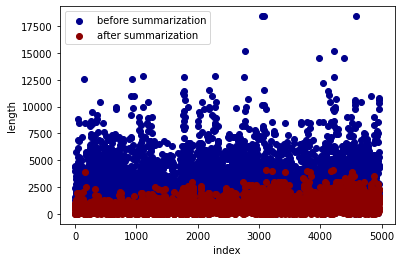

In [14]:
plt.scatter(new_df.index, new_df.transcription_len,c='DarkBlue')
plt.scatter(new_df.index, new_df.transcription_T5_len,c='DarkRed')
plt.xlabel("index")
plt.ylabel("length")
plt.legend(['before summarization','after summarization'])
plt.show()

In [18]:
new_df.transcription_T5_len.max()

4081.0

In [19]:
new_df.transcription_T5_len.min()

0.0